In [0]:
!pip install cartoframes==1.0.2
!pip install geopandas
# !pip install geopy

  Found existing installation: google-resumable-media 0.4.1
    Uninstalling google-resumable-media-0.4.1:
      Successfully uninstalled google-resumable-media-0.4.1


In [0]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib import pyplot as plt

import geopandas as gpd

# from cartoframes.viz.helpers import color_bins_layer
from cartoframes.viz import color_continuous_style,color_category_style
from google.cloud import bigquery
from shapely import wkt
from geopandas import GeoDataFrame, points_from_xy
from cartoframes.viz import Map,Layer,size_continuous_style

bq_client = bigquery.Client('eci-workspace-rachel')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


In [0]:
# df= pd.read_csv('temp.csv')

q =  '''
select *
from eci-workspace-rachel.coronvirus_NL.summary_rivm_NL_covid19_hosp_municipality
'''
df = bq_client.query(q).to_dataframe()

In [0]:
df['Datum'] = pd.to_datetime(df['Datum'],format='%Y-%m-%d')
df['day'] = df['Datum'].dt.day
df['weekday'] = df['Datum'].dt.weekday
df['month'] = df['Datum'].dt.month

In [0]:
df.drop(columns = ['Datum','Datum_yes2'],inplace = True)

In [0]:
df.isnull().any().any()

False

In [0]:
df = df.rename(columns = {'Aantal':'Coronavirus_Anatal','Provincie_aantal':'Provincie_Coronavirus_Aantal',
           'Aantal_yes':'Coronavirus_Anatal_Yesterday','Provincie_aantal_yes':'Provincie_Coronavirus_Aantal_Yes',
           'Aantal_y':'Coronavirus_Aantal_yes2','Provincie_aantal_yes2':'Provincie_Coronavirus_aantal_yes2',
           'Aantal_yes3':'Coronavirus_Anatal_yes3','Provincie_aantal_yes3':'Provincie_Coronavirus_Aantal_yes3',
           'record_count':'Health_Organization_Amount','doc_record_count':'Health_Doc_Amount',
           'day':'Coronavirus_Day','weekday':'Coronavirus_Weekday','month':'Coronavirus_Month'})

In [0]:
df.columns

Index(['Gemeentenaam', 'Provincienaam', 'Coronavirus_Anatal', 'Provincie_Coronavirus_Aantal', 'Coronavirus_Anatal_Yesterday', 'Provincie_Coronavirus_Aantal_Yes', 'Coronavirus_Aantal_yes2', 'Provincie_Coronavirus_aantal_yes2', 'Coronavirus_Anatal_yes3', 'Provincie_Coronavirus_Aantal_yes3', 'outbreak_days', 'high_temp_degree', 'low_temp_degree', 'hist_Gemiddeld_degree_low', 'hist_Gemiddeld_degree_high', 'Gemeenten2016_Bevolking', 'Gemeenten2016_Beweegrichtlijnen', 'Gemeenten2016_Eenzaam', 'Gemeenten2016_Ernstig_zeerernstigeenzaam', 'Gemeenten2016_Ernstigehinderspoorwegen', 'Gemeenten2016_Ernstigehindervliegtuigen', 'Gemeenten2016_Ernstigehinderwegenless_than_50km_u', 'Gemeenten2016_Ernstigehinderwegenmore_than_50km_u', 'Gemeenten2016_Gehoorbeperking', 'Gemeenten2016_Gezichtsbeperking', 'Gemeenten2016_Goed_zeergoedervarengezondheid', 'Gemeenten2016_Hoogrisicoopangstofdepressie', 'Gemeenten2016_Langdurigeziekteofaandoening', 'Gemeenten2016_Mantelzorger',
       'Gemeenten2016_Mantelzorgont

# Finding important factors in coronvirus infection: 

Aim: Finding linear/non-linear relationship between features and infected coronvirus infected number (city based).  Since lacking many important info (s.t. patient info), I do not predict infected number. 

## Data(feature) explanation:

Coronavirus data in netherlandas are collected from [rivm_NL_covid19_total_municipality.csv](https://github.com/J535D165/CoronaWatchNL/blob/master/data/rivm_NL_covid19_total_municipality.csv), which contains 'Datum','Gemeentenaam','Gemeentecode,'Provincienaam', and 'Aantal' fields.  Aantal field is renamed into Coronavirus_Anatal. Through feature engineering, some new features are created: 

| New Features  | Explanation |
| -------- | --------|
| Coronavirus_Anatal_Yesterday    |  infected numbers at yesterday  |
| Coronavirus_Aantal_yes2     | infected numbers at the day before yesterday  | 
| Coronavirus_Anatal_yes3     | infected numbers 3 days ago | 
| Provincie_Coronavirus_Aantal | infected patient number in the province level   |
| Provincie_Coronavirus_Aantal_Yes     | infected numbers at yesterday in the province level  | 
| Provincie_Coronavirus_aantal_yes2     | infected numbers 2 days ago in the province level  | 
| Provincie_Coronavirus_Aantal_yes3     | infected numbers 3 days ago in the province level  | 
| outbreak_days     | current date - the first patient infected date (2020-02-27) | 
| Coronavirus_Day     | The day of 'Datum', s.t. for 'Datum' 2020-02-27, Coronavirus_Day=27   | 
| Coronavirus_Weekday     | The week day of 'Datum', s.t. sunday=0| 
| Coronavirus_Month     | The month of 'Datum'  | 


Weather data is colllected form [accuweather](https://www.accuweather.com/) for each municipalities and date (from feb to now, which is april).

| Feature name  | Explanation |
| -------- | --------|
| high_temp_degree    |  highest temperature in that date  |
| low_temp_degree    |  lowest temperature in that date  |
| hist_Gemiddeld_degree_low    |  averaged highest temperature history  |
| hist_Gemiddeld_degree_high    |  averaged lowest temperature history  |


Data are also collected from [rivm](https://www.rivm.nl/). Features are named starting with ''gemeenten2016'.

Info about heathcare organization and providers (s.t. dentists, nurses,pharmacists etc) are also collected from [zorgkaartnederland](https://www.zorgkaartnederland.nl/). 

| Feature name  | Explanation |
| -------- | --------|
| Health_Organization_Amount    |  How many healthcare organization in each municipality|
| Health_Doc_Amount    |  How many healthcare providers in each municipality  |
   

### Linear relationship (correlation)

coronavirus_aantal has a weak positive linear relationshap with some features, which are: `
'Provincie_coronavirus_aantal','Coronavirus_anatal_yes2','Coronavirus_anatal_yes3','outbreak_days',
'high_temp_degree','hist_Gemiddeld_degree_low','hist_Gemiddeld_degree_high','Gemeenten2016_Bevolking',
'health_organization_amount','heath_doc_amount','coronavirus_Month'`

Positive relationship means if feature get strong (s.t. `coronavirus_Month` goes up) then the infected number highly possible goes up.

NumExpr defaulting to 2 threads.


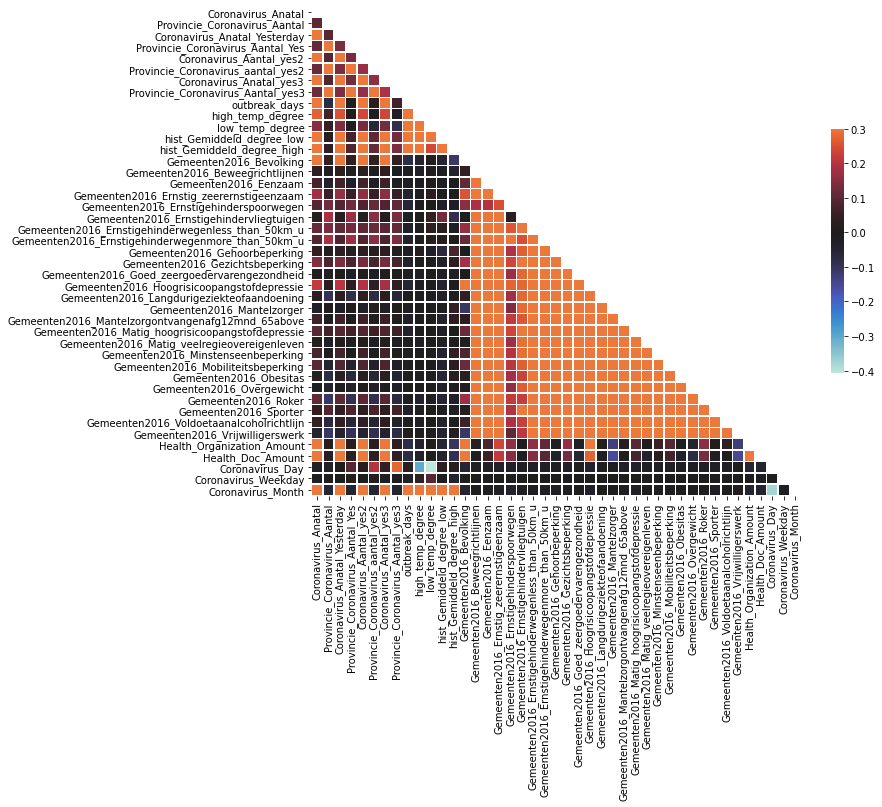

In [0]:
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}) # cmap=cmap,

### Non-linear relationship 
Feature importance from RandForest and Permutation Importance. 

Finding: `Coronavirus_aantal_yesterday`(yesterday infected number) plays a big role (around 0.4 importance). `Health_Organizatin_Amount`(how many health-organization in the city), `Gemeenten2016_Bevolking`(city populatin) and `Health_doc_amount` (how many doctors in the city) somehow weakly influece the infected number. 

In [0]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression

In [0]:
y = df['Coronavirus_Anatal']
X = df.drop(columns = ['Coronavirus_Anatal'])

rng = np.random.RandomState(seed=42)
X['random_cat'] = rng.randint(3, size=X.shape[0])
X['random_num'] = rng.randn(X.shape[0])

categorical_columns = ['Gemeentenaam','Provincienaam']
numerical_columns = ['Provincie_Coronavirus_Aantal', 'Coronavirus_Anatal_Yesterday', 'Provincie_Coronavirus_Aantal_Yes', 'Coronavirus_Aantal_yes2', 'Provincie_Coronavirus_aantal_yes2', 'Coronavirus_Anatal_yes3', 'Provincie_Coronavirus_Aantal_yes3', 'outbreak_days', 'high_temp_degree', 'low_temp_degree', 'hist_Gemiddeld_degree_low', 'hist_Gemiddeld_degree_high', 'Gemeenten2016_Bevolking', 'Gemeenten2016_Beweegrichtlijnen', 'Gemeenten2016_Eenzaam', 'Gemeenten2016_Ernstig_zeerernstigeenzaam', 'Gemeenten2016_Ernstigehinderspoorwegen', 'Gemeenten2016_Ernstigehindervliegtuigen', 'Gemeenten2016_Ernstigehinderwegenless_than_50km_u', 'Gemeenten2016_Ernstigehinderwegenmore_than_50km_u', 'Gemeenten2016_Gehoorbeperking', 'Gemeenten2016_Gezichtsbeperking', 'Gemeenten2016_Goed_zeergoedervarengezondheid', 'Gemeenten2016_Hoogrisicoopangstofdepressie', 'Gemeenten2016_Langdurigeziekteofaandoening', 'Gemeenten2016_Mantelzorger',
       'Gemeenten2016_Mantelzorgontvangenafg12mnd_65above', 'Gemeenten2016_Matig_hoogrisicoopangstofdepressie', 'Gemeenten2016_Matig_veelregieovereigenleven', 'Gemeenten2016_Minstenseenbeperking', 'Gemeenten2016_Mobiliteitsbeperking', 'Gemeenten2016_Obesitas', 'Gemeenten2016_Overgewicht', 'Gemeenten2016_Roker', 'Gemeenten2016_Sporter', 'Gemeenten2016_Voldoetaanalcoholrichtlijn', 'Gemeenten2016_Vrijwilligerswerk', 
        'Health_Organization_Amount', 'Health_Doc_Amount', 'Coronavirus_Day', 'Coronavirus_Weekday', 'Coronavirus_Month']


X = X[categorical_columns + numerical_columns]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42) #stratify=y

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', AdaBoostRegressor(random_state=42,n_estimators=50))
])
rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

In [0]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

print("explained_variance",explained_variance_score(y_train, rf.predict(X_train)))
print("max_error",max_error(y_train,  rf.predict(X_train)))
print("mean absolute error:",mean_absolute_error(y_train, rf.predict(X_train)))
print("mean squared：",mean_squared_error(y_train, rf.predict(X_train)))
print("medain absolute error:",median_absolute_error(y_train, rf.predict(X_train)))
print("r2 (coefficient of determination) score:",r2_score(y_train, rf.predict(X_train)))

explained_variance 0.9249969826275758
max_error 162.42757821552723
mean absolute error: 35.287951750597585
mean squared： 1547.5625565019534
medain absolute error: 39.18276563294357
r2 (coefficient of determination) score: 0.8422768031389714


In [0]:
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 0.842
RF test accuracy: 0.840


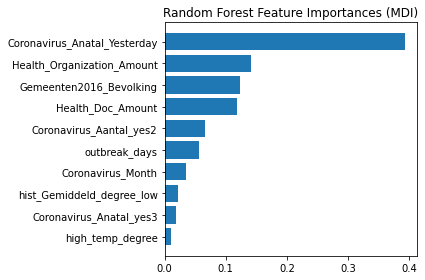

In [0]:
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    rf.named_steps['regressor'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))[-10:]
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx][-10:,])
ax.set_yticklabels(feature_names[sorted_idx][-10:,])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

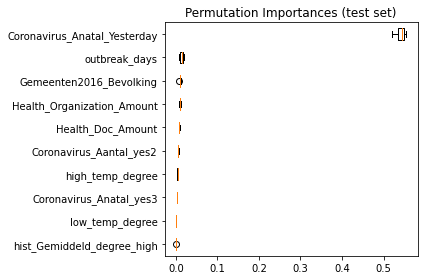

In [0]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T[:,-10:],
           vert=False, labels=X_test.columns[sorted_idx][-10:])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

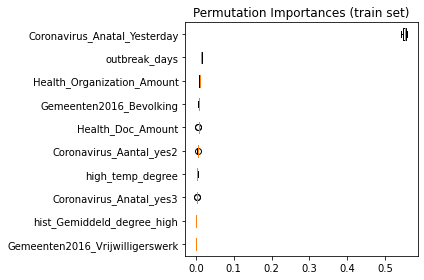

In [0]:
result = permutation_importance(rf, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T[:,-10:],
           vert=False, labels=X_train.columns[sorted_idx][-10:])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

# Open dataset
## Collecting data from [zorgkaartnederland](https://www.zorgkaartnederland.nl/)

This dataset provide heathcare provider (organization & person) infomation. 

There are 4 tables in Bigquery dataset `zorgkaartnederland`:
- `care_provider_organization`: 
Raw data collected from [this webpage](https://www.zorgkaartnederland.nl/overzicht/organisatietypes) and its all sublinks (organization detail page). This table contains 
  - `organization_name_x`(organization name from organization detail page), 
  - `other_info`(description info about organization from detail page),
  - `link` (detail page link),
  - `organization_name_y`(organization name from categorized page, such as [abortion clinics](https://www.zorgkaartnederland.nl/abortuskliniek)),
  - `parent_link`(categorized page),
  - `healthCare_type` (health care type from categorized page, such as abortion)

- care_provider_organization_GIS:
  based on the `care_provider_organization` table, but extract info from `other_info` column and add some geo info. This table contains columns:
  `address`,`postcode`,`city`,`tel`,`organization_name`,`healthCare_type`,`place_name`,`state_name`,`state_code`,`county_name`,`county_code`,`community_name`,`community_code`,`latitude`,`longitude`,`web`,`remark`,`link`.

- care_provider_person: Raw data collected from (this page)[https://www.zorgkaartnederland.nl/overzicht/beroepen] and its sublinks. 
- care_provider_person_GIS:
  Extract personal information abot healthcare practioners and combined geo info of his/her working organization. Columns in this table are: 
  `Geslacht`,`Specialisme`,`Werkplaats`,`other_info`,`doc_nam`,`job`,`org_address`,`org_postcode`,`org_city`,`org_tel`,`org_web`,`org_remark`,	`org_name`,`org_type`,	`org_place_name`,`org_state_name`,`org_county_name`,`org_latitude`,`org_longitude`.  Column name starts with 'org_' means organization-related infomation. 

## Research question:

some possble questions are:
1. The geo-distribution about heathcare organization?
2. The organization amount for different heathcare types ?
3. Healthcare organziation geo-distribution for `Fysiotherapiepraktijk`?
4. Geo-distirbution for hethcare practitioners? For different cities and jobs?

Feel free to try other questions.


### The geo-distribution about heathcare organization?

In [0]:
def map_bq(query):
  df = bq_client.query(q).to_dataframe()

  df = df[df['longitude'].notna()]
  gdf = GeoDataFrame(df, geometry=points_from_xy(df['longitude'], df['latitude']))
  return gdf

I use 'pgeocode 0.2.1' pacakage to add latitude and longtitude for each orgnization by postcode (only digits without letters).  So several orgnizations with the same digital postcode are displayed in one same point, while 'total organization amount' of that point is indicated by color (as shown in the legend)

In [0]:
q = '''
SELECT latitude, longitude,  count(*) as org_amount
from eci-workspace-rachel.zorgkaartnederland.care_provider_organization_GIS
group by latitude, longitude
'''
org_dist = map_bq(q)
Map(Layer(org_dist,color_continuous_style('org_amount'), title='Total healthcare organization amount'))

### 2. The organization amount for different heathcare types ?
There are 80 different healthcare orgnizations.

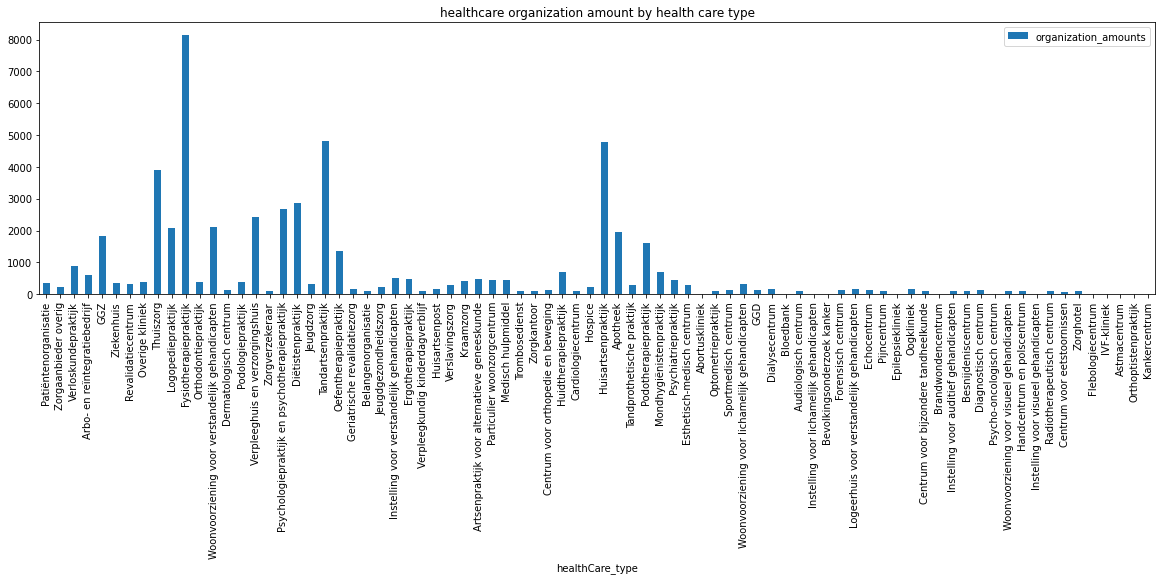

In [0]:
q = '''
SELECT healthCare_type, count(*) as organization_amounts
from eci-workspace-rachel.zorgkaartnederland.care_provider_organization_GIS
group by healthCare_type
'''

bq_client.query(q).to_dataframe().plot.bar(x='healthCare_type', 
                                           y ='organization_amounts',figsize=(20,5), 
                                           title = 'healthcare organization amount by health care type')

In [0]:
org_dist['org_amount'].describe()

count    3103.000000
mean       17.475024
std        17.631333
min         1.000000
25%         4.000000
50%        12.000000
75%        26.000000
max       136.000000
Name: org_amount, dtype: float64

### 3. Healthcare organziation geo-distribution for `Fysiotherapiepraktijk`?

In [0]:
from cartoframes.viz import formula_widget, category_widget

q = '''
SELECT latitude, longitude,healthCare_type,  count(*) as org_amount
from eci-workspace-rachel.zorgkaartnederland.care_provider_organization_GIS
group by latitude, longitude,healthCare_type
'''
org_dist = map_bq(q)
most_freq_healthcaretypes = org_dist.groupby(['healthCare_type'])['org_amount']\
                            .sum().reset_index(name='org_amount_sum')\
                            .sort_values('org_amount_sum',ascending=False)\
                            .head(4)['healthCare_type']\
                            .values.tolist()

In [0]:
Map(Layer(org_dist[org_dist['healthCare_type'] == most_freq_healthcaretypes[0]],
          color_continuous_style('org_amount'), title='Total healthcare organization amount for '+most_freq_healthcaretypes[0]))

4. Geo-distirbution for hethcare practitioners? For different cities and jobs?

In [0]:
from cartoframes.viz import formula_widget, category_widget

q = '''
SELECT org_latitude as latitude, org_longitude as longitude, org_city as city ,count(*) as doc_amount
from eci-workspace-rachel.zorgkaartnederland.care_provider_person_GIS
where org_city is not null
group by org_latitude, org_longitude,org_city
'''
org_dist = map_bq(q)

Map([
    Layer(
        org_dist,
        widgets=[
            formula_widget(
                'doc_amount',
                'sum',
                title='Total Doctor Population Served'
            ),
            category_widget(
                'city',
                title='city'
            )
        ]
    ),
    Layer(
        org_dist,
        size_continuous_style('doc_amount')
    )
])


In [0]:
from cartoframes.viz import popup_element

q = '''
SELECT org_latitude as latitude, org_longitude as longitude, job, count(*) as doc_amount
from eci-workspace-rachel.zorgkaartnederland.care_provider_person_GIS
where job is not null
group by org_latitude, org_longitude,job
'''
org_dist = map_bq(q)
org_dist['job'] = org_dist['job'].astype('category')
Map([
     Layer(org_dist,
          widgets=[
            formula_widget(
                'doc_amount',
                'sum',
                title='Total Doctors Population Served'
            ),
            category_widget(
                'job',
                title='occupation'
            )
        ],
        popup_hover=[
            popup_element('job', title='occupation')
        ]
    ),
    Layer(
        org_dist,
        size_continuous_style('doc_amount')
    )]
)

## Weather info from [accuweather](https://www.accuweather.com/)

Tables are `accuweather_april`,`accuweather_current`,`accuweather_feb` and `accuweather_march`. Tables contains the lowest and highest temperature, history averaged highest/lowerst temperature for each day.

#### Research questions:
- Plot the averaged temperatures from feb to april (averaged among cities).
- plot enschede weather from feb to april.

[Text(0, 0.5, 'Temperature (degree)'),
 Text(0.5, 0, 'Datum'),
 Text(0.5, 1.0, 'Temperature for enschede')]

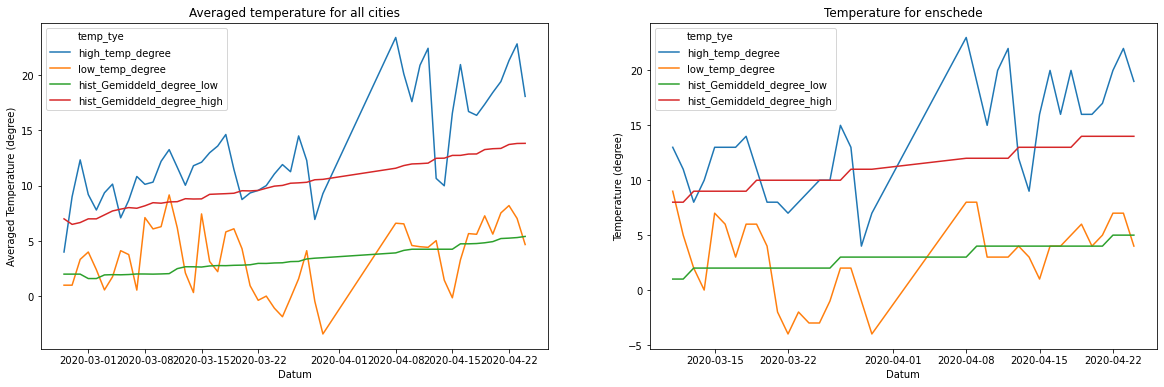

In [0]:

q_average_cities = '''
select Datum, avg(high_temp_degree) as high_temp_degree, avg(low_temp_degree) as low_temp_degree,  
avg(hist_Gemiddeld_degree_low) as hist_Gemiddeld_degree_low, 
avg(hist_Gemiddeld_degree_high) as hist_Gemiddeld_degree_high
from eci-workspace-rachel.coronvirus_NL.summary_rivm_NL_covid19_hosp_municipality
group by Datum
'''

# pivot table to change multiple columns into one column
temp = (bq_client.query(q_average_cities).to_dataframe().set_index(['Datum']).stack().rename_axis(['Datum','temp_tye']).rename('temp_degree').reset_index())

q_enschede = '''
select Datum, high_temp_degree, low_temp_degree, hist_Gemiddeld_degree_low, hist_Gemiddeld_degree_high
from eci-workspace-rachel.coronvirus_NL.summary_rivm_NL_covid19_hosp_municipality
where Gemeentenaam = 'enschede'
'''
# pivot table to change multiple columns into one column
enschede_temp = (bq_client.query(q_enschede).to_dataframe().set_index(['Datum']).stack().rename_axis(['Datum','temp_tye']).rename('temp_degree').reset_index())


f, axes = plt.subplots(1, 2,figsize=(20,6))
sns.lineplot(x='Datum', y='temp_degree',hue='temp_tye', data=temp,ax=axes[0])\
        .set(title = 'Averaged temperature for all cities', 
             xlabel = 'Datum', 
             ylabel = 'Averaged Temperature (degree)' )
sns.lineplot(x='Datum', y='temp_degree',hue='temp_tye', data=enschede_temp, ax=axes[1])\
        .set(title = 'Temperature for enschede', 
             xlabel = 'Datum', 
             ylabel = 'Temperature (degree)' )
      

# Open dataset from [vetkis](https://www.vektis.nl/open-data). 

## dataset explanation:
This dataset contains <b>health insurance information</b> from 2011 to 2017 on <b>municipal</b> and <b>individual</b> level.  
<br/>
On municipal level, dataset contains `'GESLACHT', 'LEEFTIJDSKLASSE', 'GEMEENTENAAM', 'AANTAL_BSN', 'AANTAL_VERZEKERDEJAREN', 'KOSTEN_MEDISCH_SPECIALISTISCHE_ZORG', 'KOSTEN_FARMACIE', 'KOSTEN_SPECIALISTISCHE_GGZ', 'KOSTEN_HUISARTS_INSCHRIJFTARIEF', 'KOSTEN_HUISARTS_CONSULT', 'KOSTEN_HUISARTS_MDZ', 'KOSTEN_HUISARTS_OVERIG', 'KOSTEN_HULPMIDDELEN', 'KOSTEN_MONDZORG', 'KOSTEN_PARAMEDISCHE_ZORG_FYSIOTHERAPIE', 'KOSTEN_PARAMEDISCHE_ZORG_OVERIG', 'KOSTEN_ZIEKENVERVOER_ZITTEND', 'KOSTEN_ZIEKENVERVOER_LIGGEND', 'KOSTEN_KRAAMZORG', 'KOSTEN_VERLOSKUNDIGE_ZORG', 'KOSTEN_GENERALISTISCHE_BASIS_GGZ', 'KOSTEN_LANGDURIGE_GGZ', 'KOSTEN_GRENSOVERSCHRIJDENDE_ZORG', 'KOSTEN_EERSTELIJNS_ONDERSTEUNING', 'KOSTEN_GERIATRISCHE_REVALIDATIEZORG', 'KOSTEN_VERPLEGING_EN_VERZORGING', 'KOSTEN_OVERIG'` columns. For each city, all costs are summed for Male(M) and Female(V) and different age groups (19 age groups, s.t, 0-4 years old, 4-9 years old, etc). For example, if you want to search insurance information about 0-4 years old males in ALMELO, then: 
```
SELECT *
from eci-workspace-rachel.vetkis.VektisOpenDatabestandZorgverzekeringswet2017gemeente
where LEEFTIJDSKLASSE ='0 t/m  4 jaar' and GESLACHT ='M' and GEMEENTENAAM = 'ALMELO'
```  
<br/>


On the individual level, dataset contains the similar fields. The age shows the real age instead of age group. For example, 
``` 
SELECT distinct(LEEFTIJDSKLASSE)
from eci-workspace-rachel.vetkis.VektisOpenDatabestandZorgverzekeringswet2017postcode3
``` 
is sql searching 2017 individual insurance info. This sql will return 136,821 records.
<br/>

## Example research questions

4 questions are came up: 
1. On municaipal level, what are top 10 cities with the most total/averaged cost for male/famle ? what are these cost items? (use sum/mean)

2. On municipal level, what is the relative biggest/smallest cost for each age group ? 
  - sum and average over city level for each age group to check difference.

3. On municipal level, what is the relative biggest/smallest cost for each male/femal age group ? 
  - median over cities for each female/male age group

4. On dividual level, what is the most/least costy item for different age? And what's more costy item for male/female?

There are more questions could be asked, such as: 
- On dividual level, what is the most/least costy item for different gender? 

- For each cost item, which city cost most/least? What about after averaging the population for each city? how about on geneder level? 

You could also combine other information from other datasets, such as illness municaipal distribution from rivm datset, healthcare orgnization and persons info from zorgkaartnederland dataset, population characteristics from public_dataset_NL dataset. 





In [0]:
q_insurer_gem = '''
SELECT *
from eci-workspace-rachel.vetkis.VektisOpenDatabestandZorgverzekeringswet2017gemeente
'''
insuer_gemeente = bq_client.query(q_insurer_gem).to_dataframe()

In [0]:
q_geo_info = '''
SELECT *
from eci-workspace-rachel.vetkis.coordiantion2017gemeente
'''
city_geo_info = bq_client.query(q_geo_info).to_dataframe()

In [0]:
city_geo_info.columns

Index(['GEMEENTENAAM', 'address', 'location'], dtype='object')

In [0]:
# change stored list in string format into list format 
from ast import literal_eval
city_geo_info['location'] = city_geo_info['location'].apply(lambda x: literal_eval(x))

city_geo_info['north_lat'] = city_geo_info['location'].apply(lambda x: x[0]['geometry']['viewport']['northeast']['lat'] if len(x)==1 else None)
city_geo_info['south_lat'] = city_geo_info['location'].apply(lambda x: x[0]['geometry']['viewport']['southwest']['lat'] if len(x)==1 else None)
city_geo_info['north_lng'] = city_geo_info['location'].apply(lambda x: x[0]['geometry']['viewport']['northeast']['lng'] if len(x)==1 else None)
city_geo_info['south_lng'] = city_geo_info['location'].apply(lambda x: x[0]['geometry']['viewport']['northeast']['lng'] if len(x)==1 else None)

In [0]:
city_geo_info[city_geo_info['north_lat'].isnull()]

GEMEENTENAAM                           address                                           location  north_lat  south_lat  north_lng  south_lng
166            WAADHOEKE            waadhoeke, Netherlands                                                 []        NaN        NaN        NaN        NaN
272            NUENEN CA            nuenen ca, Netherlands  [{'address_components': [{'long_name': 'Nuenen...        NaN        NaN        NaN        NaN
276  BODEGRAVEN-REEUWIJK  bodegraven-reeuwijk, Netherlands  [{'address_components': [{'long_name': 'Bodegr...        NaN        NaN        NaN        NaN

In [0]:
city_geo_info =city_geo_info[city_geo_info.notna()]
insuer_gemeente = pd.merge(insuer_gemeente,city_geo_info, on='GEMEENTENAAM', how='left')

insuer_gemeente[insuer_gemeente['GEMEENTENAAM'].notna()].head(5)

GESLACHT LEEFTIJDSKLASSE         GEMEENTENAAM  AANTAL_BSN  AANTAL_VERZEKERDEJAREN  KOSTEN_MEDISCH_SPECIALISTISCHE_ZORG  KOSTEN_FARMACIE  KOSTEN_SPECIALISTISCHE_GGZ  KOSTEN_HUISARTS_INSCHRIJFTARIEF  KOSTEN_HUISARTS_CONSULT  KOSTEN_HUISARTS_MDZ  KOSTEN_HUISARTS_OVERIG  KOSTEN_HULPMIDDELEN  KOSTEN_MONDZORG  KOSTEN_PARAMEDISCHE_ZORG_FYSIOTHERAPIE  KOSTEN_PARAMEDISCHE_ZORG_OVERIG  KOSTEN_ZIEKENVERVOER_ZITTEND  KOSTEN_ZIEKENVERVOER_LIGGEND  KOSTEN_KRAAMZORG  KOSTEN_VERLOSKUNDIGE_ZORG  KOSTEN_GENERALISTISCHE_BASIS_GGZ  KOSTEN_LANGDURIGE_GGZ  KOSTEN_GRENSOVERSCHRIJDENDE_ZORG  KOSTEN_EERSTELIJNS_ONDERSTEUNING  KOSTEN_GERIATRISCHE_REVALIDATIEZORG  KOSTEN_VERPLEGING_EN_VERZORGING  KOSTEN_OVERIG                           address                                           location  north_lat  south_lat  north_lng  south_lng
1        M   0 t/m  4 jaar        ACHTKARSPELEN         757                  684.08                           1075871.94         66641.03                         0.0                         38111.26                 18972.11                33.84                60734.50             20159.06         15271.59                                27082.34                         39029.84                      17177.65                      14526.57               0.0                        0.0                               0.0                    0.0                            129.90                            869.50                                  0.0                         98187.84      121614.39        achtkarspelen, Netherlands  [{'address_components': [{'long_name': 'Achtka...  53.269970  53.145036   6.235144   6.235144
2        M   0 t/m  4 jaar              ALKMAAR        2832                 2525.35                           3361436.59        181252.87                         0.0                        142596.49                 70667.09               404.06               170565.77             61331.95         69558.21                                83043.47                        111707.63                       4654.04                      67984.74               0.0                        0.0                               0.0                    0.0                          70014.49                             71.91                                  0.0                        123774.06      264663.35              alkmaar, Netherlands  [{'address_components': [{'long_name': 'Alkmaa...  52.675541  52.591698   4.800460   4.800460
3        M   0 t/m  4 jaar               ALMELO        1813                 1644.83                           1971553.00        170642.15                         0.0                         95526.80                 52027.22               161.00               167510.34             23664.74         36222.02                                56173.36                        119896.02                       2294.52                      30053.26               0.0                        0.0                               0.0                    0.0                           1700.09                             38.54                                  0.0                         63225.22      288356.84               almelo, Netherlands  [{'address_components': [{'long_name': 'Almelo...  52.399341  52.322607   6.721089   6.721089
4        M   0 t/m  4 jaar               ALMERE        6231                 5615.37                           8907799.17        601736.84                         0.0                        316783.40                184026.19            105303.50               452766.09            212962.27        192823.96                               119410.91                        280687.37                      38944.12                     127377.00               0.0                        0.0                               0.0                    0.0                          20051.97                            228.42                                  0.0                        627564.64      982818.00            

In [0]:
## what the most diffrent total cost betweeen womem and man ?

def group_df(insuer_gemeente,group_type,accord_col):
  cost_list = list(
      set(insuer_gemeente.columns) - 
      set(['address', 'location', 'north_lat', 'south_lat', 'north_lng', 'south_lng','GESLACHT', 'GEMEENTENAAM', 'LEEFTIJDSKLASSE','AANTAL_BSN'])
      )
  cost_dict_sum = {}
  for cost_item in cost_list:
    cost_dict_sum[cost_item]=group_type

  temp = insuer_gemeente.groupby(accord_col)\
                .agg(cost_dict_sum).reset_index()
  return temp

def subtract_dfs(temp,accord_col,accord_vals_list):
  temp_M = temp[temp[accord_col] == accord_vals_list[0]].drop(columns = {'north_lat','north_lng','south_lat','south_lng',accord_col})
  temp_F = temp[temp[accord_col] == accord_vals_list[1]].drop(columns = {'north_lat','north_lng','south_lat','south_lng',accord_col})
  temp = temp_M.set_index('GEMEENTENAAM').subtract(temp_F.set_index('GEMEENTENAAM'), fill_value=0).reset_index()
  return temp

In [0]:
def get_compares_df(temp, compare_col_name,col_name,drop_col_list):
  temp = temp[temp.notna()]
  id_list = temp[compare_col_name].unique()
  assert temp.shape[0] == len(id_list)

  id_groups = temp[compare_col_name].values.tolist()
  id_compares = pd.DataFrame(data = {col_name:id_groups})

  for id_group in id_groups:
    temp_filtered = temp[temp[compare_col_name]==id_group].drop(columns= drop_col_list)\
                                                    .replace(0,np.nan)\
                                                    .dropna(axis=1,how="all")

    id_compares.loc[id_compares[col_name] == id_group, 'smallest_cost_item'] = temp_filtered.drop(columns = {compare_col_name}).idxmin(axis=1).values[0]
    id_compares.loc[id_compares[col_name] == id_group, 'smallest_cost_val'] =  temp_filtered.min(axis=1).values[0]

    id_compares.loc[id_compares[col_name] == id_group, 'biggest_cost_item'] = temp_filtered\
                                                                            .drop(columns = {compare_col_name})\
                                                                            .idxmax(axis=1).values[0]

    id_compares.loc[id_compares[col_name] == id_group, 'biggest_cost_val'] =  temp_filtered.max(axis=1).values[0]

  return id_compares


def plot_small_biggest(city_compares, b_title,b_xlabel,s_title,s_xlabel,
                       head_num,comp_col, figuresize = (20,6),
                       sort_big_col='biggest_cost_val',sort_small_col='smallest_cost_val'):
  f, axes = plt.subplots(1, 2,figsize=figuresize)

  top_10 = city_compares.sort_values(by =sort_big_col).tail(head_num)
  top_10.plot.barh(x=comp_col, y='biggest_cost_val',
                        legend=False,
                        title= b_title,
                        ax=axes[0])
  axes[0].set_xlabel(b_xlabel)
  big_vals = top_10['biggest_cost_val'].values.tolist()

  for i, v in enumerate(top_10['biggest_cost_item'].values.tolist()):
      axes[0].text(big_vals[i]+3, i-.05, str(v), color='blue', fontweight='bold')


  top_10_s = city_compares.sort_values(by = sort_small_col ,ascending=False).tail(head_num)
  top_10_s['smallest_cost_val'] = top_10_s['smallest_cost_val'].abs()

  top_10_s.plot.barh(x=comp_col, y='smallest_cost_val',
                          legend=False,
                          title= s_title,
                          ax=axes[1])
  axes[1].set_xlabel(s_xlabel)
  big_vals = top_10_s['smallest_cost_val'].values.tolist()

  for i, v in enumerate(top_10_s['smallest_cost_item'].values.tolist()):
      axes[1].text(big_vals[i]+3, i-.05, str(v), color='blue', fontweight='bold')


  f.tight_layout()

### 1.On municaipal level, what are top 10 cities with the most total/averaged cost for male/famle ? what are these cost items? (use sum/mean)

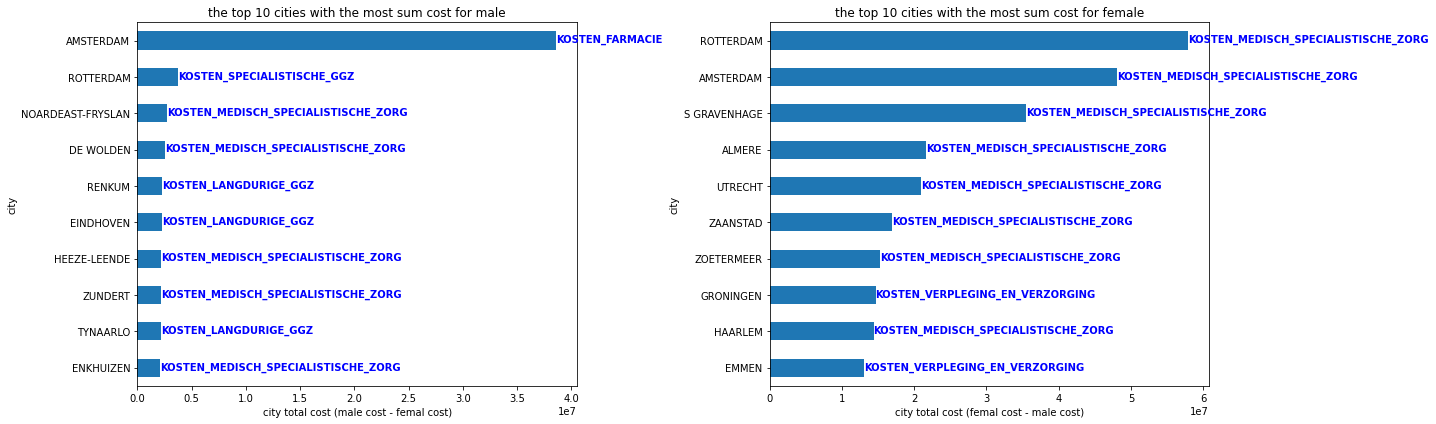

In [0]:
temp = group_df(insuer_gemeente,'sum',['GEMEENTENAAM','north_lat','north_lng','south_lat','south_lng','GESLACHT'])
temp = subtract_dfs(temp,'GESLACHT',['M','V']) # Male - Female
city_compares = get_compares_df(temp, 'GEMEENTENAAM','city',[])

plot_small_biggest(city_compares, 
                   'the top 10 cities with the most sum cost for male',
                   'city total cost (male cost - femal cost)',
                   'the top 10 cities with the most sum cost for female',
                   'city total cost (femal cost - male cost)',10,'city')

In [0]:
# how about median? 
temp = group_df(insuer_gemeente,'median',['GEMEENTENAAM','north_lat','north_lng','south_lat','south_lng','GESLACHT'])
temp = subtract_dfs(temp,'GESLACHT',['M','V']) # Male - Female

city_compares = get_compares_df(temp, 'GEMEENTENAAM','city',[])

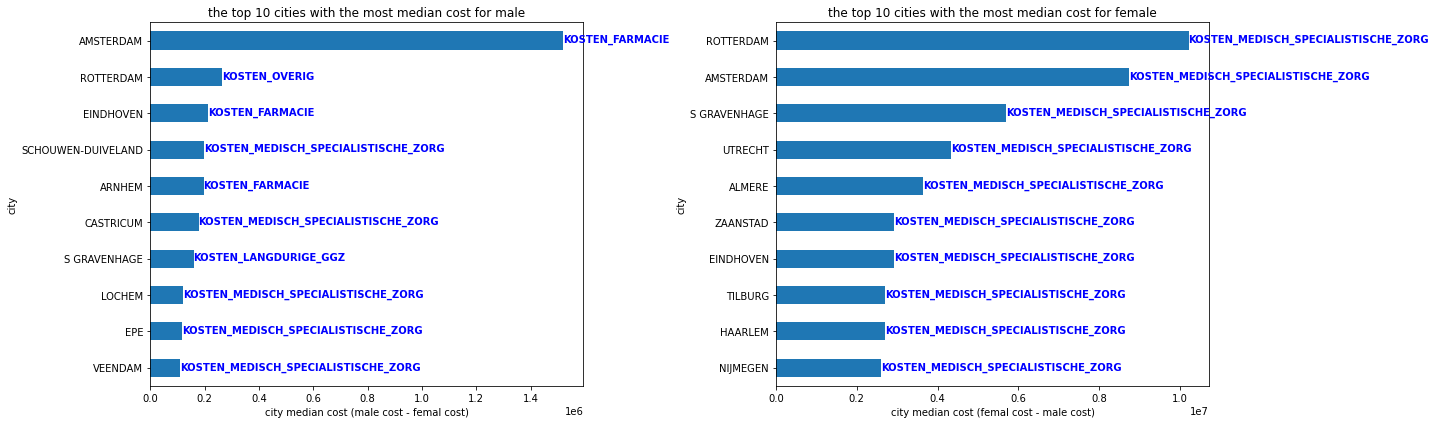

In [0]:
plot_small_biggest(city_compares, 
                   'the top 10 cities with the most median cost for male',
                   'city median cost (male cost - femal cost)',
                   'the top 10 cities with the most median cost for female',
                   'city median cost (femal cost - male cost)',10,'city')

### 2. what's the most/least costly items for different age groups?

N.B. 
1. Remove the columns that contains 0 values since most age groups have no need for some specific needs, such as maternity care
2. When calcualuate median city cost for age groups, remove `KOSTEN_EERSTELIJNS_ONDERSTEUNING` columns since it is the smallest cost for nearly most age group except 85 t/m 89 jaa and 90+
3. `KOSTEN_MEDISCH_SPECIALISTISCHE_ZORG` is the most costy item for nearly all age groups except 90+


mean of cities cost for each age group

In [0]:
## how amount different age group what is the most costy item? 
temp = group_df(insuer_gemeente,'mean',['LEEFTIJDSKLASSE'])
age_compares = get_compares_df(temp, 'LEEFTIJDSKLASSE','age_group',['KOSTEN_MEDISCH_SPECIALISTISCHE_ZORG'])
# ['AANTAL_VERZEKERDEJAREN','KOSTEN_EERSTELIJNS_ONDERSTEUNING','KOSTEN_MEDISCH_SPECIALISTISCHE_ZORG']

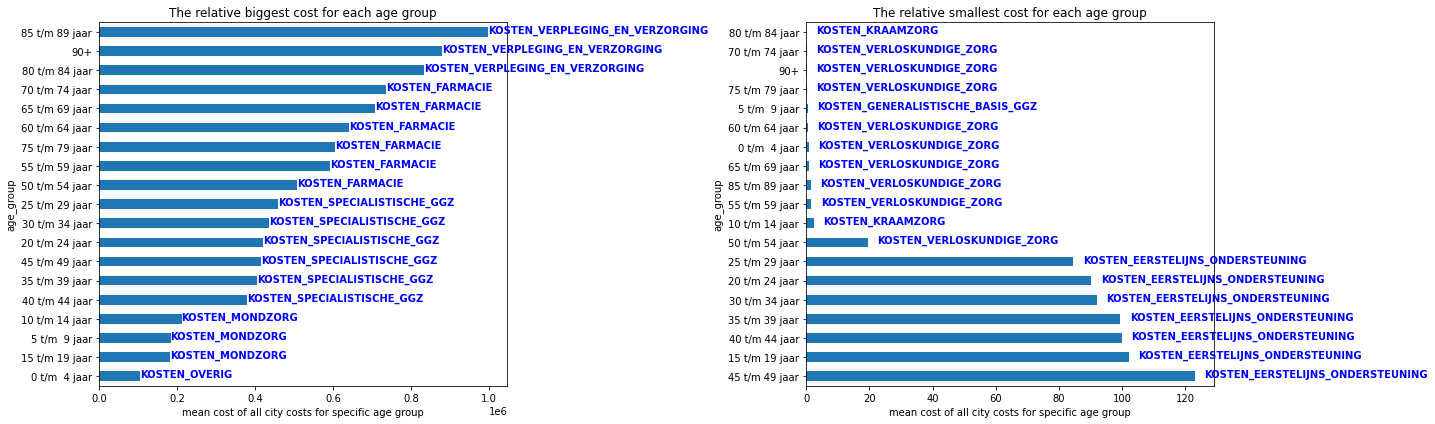

In [0]:
plot_small_biggest(age_compares, 
                   'The relative biggest cost for each age group',
                   'mean cost of all city costs for specific age group',
                   'The relative smallest cost for each age group',
                   'mean cost of all city costs for specific age group',age_compares.shape[0],'age_group')

median of cities cost for each age group

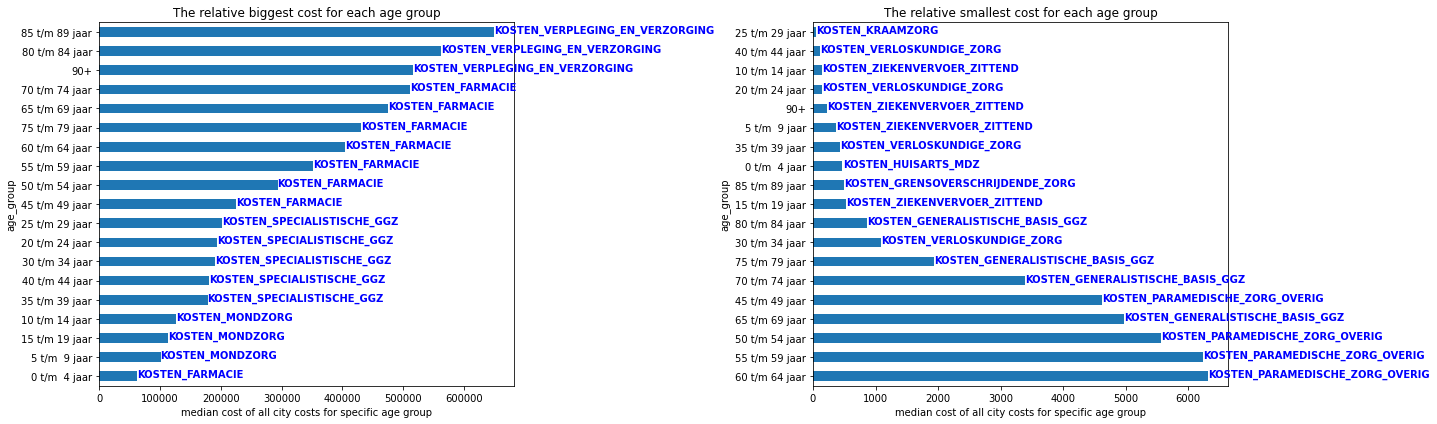

In [0]:
temp = group_df(insuer_gemeente,'median',['LEEFTIJDSKLASSE'])
age_compares = get_compares_df(temp, 'LEEFTIJDSKLASSE','age_group',
                               ['AANTAL_VERZEKERDEJAREN','KOSTEN_EERSTELIJNS_ONDERSTEUNING','KOSTEN_MEDISCH_SPECIALISTISCHE_ZORG'])

plot_small_biggest(age_compares, 
                   'The relative biggest cost for each age group',
                   'median cost of all city costs for specific age group',
                   'The relative smallest cost for each age group',
                   'median cost of all city costs for specific age group',age_compares.shape[0],'age_group')


### On municipal level, what is the relative biggest/smallest cost for each male/femal age group ?

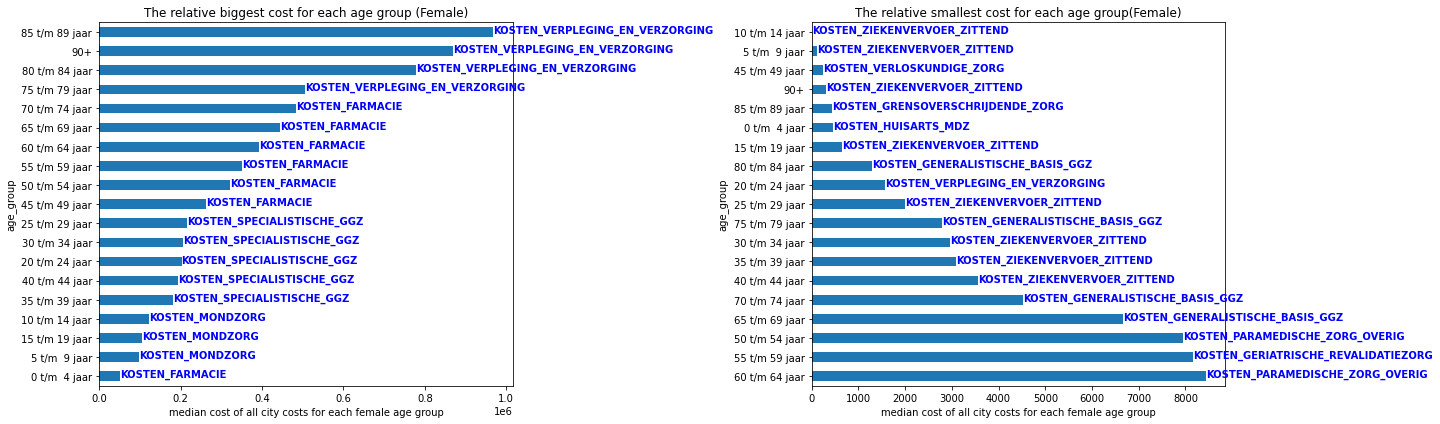

In [0]:
temp = group_df(insuer_gemeente[insuer_gemeente['GESLACHT']=='V'],'median',['LEEFTIJDSKLASSE'])
age_compares = get_compares_df(temp, 'LEEFTIJDSKLASSE','age_group',
                               ['AANTAL_VERZEKERDEJAREN','KOSTEN_EERSTELIJNS_ONDERSTEUNING','KOSTEN_MEDISCH_SPECIALISTISCHE_ZORG'])

plot_small_biggest(age_compares, 
                   'The relative biggest cost for each age group (Female)',
                   'median cost of all city costs for each female age group',
                   'The relative smallest cost for each age group(Female)',
                   'median cost of all city costs for each female age group',
                   age_compares.shape[0],'age_group')

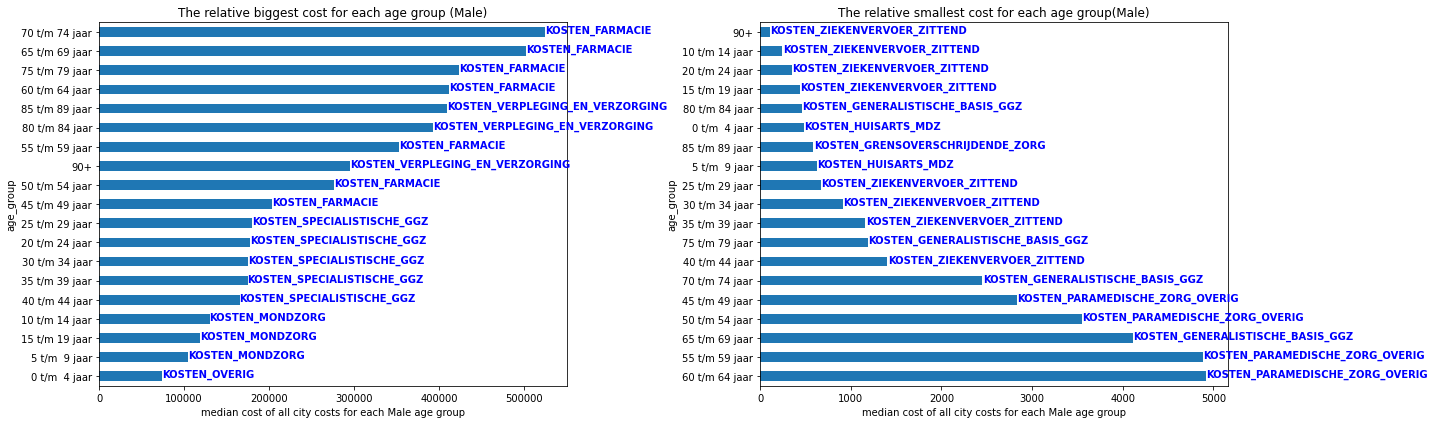

In [0]:
temp = group_df(insuer_gemeente[insuer_gemeente['GESLACHT']=='M'],'median',['LEEFTIJDSKLASSE'])
age_compares = get_compares_df(temp, 'LEEFTIJDSKLASSE','age_group',
                               ['AANTAL_VERZEKERDEJAREN','KOSTEN_EERSTELIJNS_ONDERSTEUNING','KOSTEN_MEDISCH_SPECIALISTISCHE_ZORG'])

plot_small_biggest(age_compares, 
                   'The relative biggest cost for each age group (Male)',
                   'median cost of all city costs for each Male age group',
                   'The relative smallest cost for each age group(Male)',
                   'median cost of all city costs for each Male age group',
                   age_compares.shape[0],'age_group')

### 4. On dividual level, what is the most/least costy item for different age?

In [0]:
# UPDATE   eci-workspace-rachel.vetkis.VektisOpenDatabestandZorgverzekeringswet2017postcode3 
# SET       LEEFTIJDSKLASSE = REPLACE(LEEFTIJDSKLASSE, '.0', '')
# WHERE     LEEFTIJDSKLASSE like '%.0%' 

q_avg_age = '''
SELECT LEEFTIJDSKLASSE,GESLACHT, avg(KOSTEN_MEDISCH_SPECIALISTISCHE_ZORG) as avg_KOSTEN_MEDISCH_SPECIALISTISCHE_ZORG, 
avg(KOSTEN_FARMACIE) as avg_KOSTEN_FARMACIE, 
avg(KOSTEN_SPECIALISTISCHE_GGZ) as avg_KOSTEN_SPECIALISTISCHE_GGZ, 
avg(KOSTEN_HUISARTS_INSCHRIJFTARIEF) as avg_KOSTEN_HUISARTS_INSCHRIJFTARIEF, 
avg(KOSTEN_HUISARTS_CONSULT) as avg_KOSTEN_HUISARTS_CONSULT, 
avg(KOSTEN_HUISARTS_MDZ) as avg_KOSTEN_HUISARTS_MDZ, 
avg(KOSTEN_HUISARTS_OVERIG) as avg_KOSTEN_HUISARTS_OVERIG, 
avg(KOSTEN_HULPMIDDELEN) as avg_KOSTEN_HULPMIDDELEN, 
avg(KOSTEN_MONDZORG) as avg_KOSTEN_MONDZORG, 
avg(KOSTEN_PARAMEDISCHE_ZORG_FYSIOTHERAPIE) as avg_KOSTEN_PARAMEDISCHE_ZORG_FYSIOTHERAPIE, 
avg(KOSTEN_PARAMEDISCHE_ZORG_OVERIG) as avg_KOSTEN_PARAMEDISCHE_ZORG_OVERIG, 
avg(KOSTEN_ZIEKENVERVOER_ZITTEND) as avg_KOSTEN_ZIEKENVERVOER_ZITTEND, 
avg(KOSTEN_ZIEKENVERVOER_LIGGEND) as avg_KOSTEN_ZIEKENVERVOER_LIGGEND, 
avg(KOSTEN_KRAAMZORG) as avg_KOSTEN_KRAAMZORG, 
avg(KOSTEN_VERLOSKUNDIGE_ZORG) as avg_KOSTEN_VERLOSKUNDIGE_ZORG, 
avg(KOSTEN_GENERALISTISCHE_BASIS_GGZ) as avg_KOSTEN_GENERALISTISCHE_BASIS_GGZ, 
avg(KOSTEN_LANGDURIGE_GGZ) as avg_KOSTEN_LANGDURIGE_GGZ, 
avg(KOSTEN_GRENSOVERSCHRIJDENDE_ZORG) as avg_KOSTEN_GRENSOVERSCHRIJDENDE_ZORG, 
avg(KOSTEN_EERSTELIJNS_ONDERSTEUNING) as avg_KOSTEN_EERSTELIJNS_ONDERSTEUNING, 
avg(KOSTEN_GERIATRISCHE_REVALIDATIEZORG) as avg_KOSTEN_GERIATRISCHE_REVALIDATIEZORG, 
avg(KOSTEN_VERPLEGING_EN_VERZORGING) as avg_KOSTEN_VERPLEGING_EN_VERZORGING, 
avg(KOSTEN_OVERIG) as avg_KOSTEN_OVERIG
from eci-workspace-rachel.vetkis.VektisOpenDatabestandZorgverzekeringswet2017postcode3
group by LEEFTIJDSKLASSE,GESLACHT
'''
age_costs = bq_client.query(q_avg_age).to_dataframe()

#### Finding (both genders)

- some consistence among ages in costly items (besides `avg_KOSTEN_MEDISCH_SPECIALISTISCHE_ZORG` since this is the costly items for all ages except 90+)

- the smallest costy items cost between 0-12 euros

N.B. Male and Female show the similar characters, so omit these plots

In [0]:
def get_temp(age_costs, cal_type):
  if cal_type == 'all':
    col_aves= {}
    for col in list(set(age_costs.columns) - set(['GESLACHT','LEEFTIJDSKLASSE'])):
      col_aves[col] = 'mean'
      
    temp = get_compares_df(age_costs.groupby(['LEEFTIJDSKLASSE']).agg(col_aves).reset_index(), 
                          'LEEFTIJDSKLASSE','age',['avg_KOSTEN_MEDISCH_SPECIALISTISCHE_ZORG'])
  elif cal_type == 'male':
    temp = get_compares_df(age_costs[age_costs['GESLACHT'] == 'M']\
                       .drop(columns = {'GESLACHT'}), 'LEEFTIJDSKLASSE','age',['avg_KOSTEN_MEDISCH_SPECIALISTISCHE_ZORG'])
  elif cal_type == 'female':
    # uncomment this if you want to check female
    temp = get_compares_df(age_costs[age_costs['GESLACHT'] == 'F']\
                            .drop(columns = {'GESLACHT'}), 'LEEFTIJDSKLASSE','age',['avg_KOSTEN_MEDISCH_SPECIALISTISCHE_ZORG'])
    
  # change 0,1,2,3,4,5,6,7,8,9 into 01,02,03,04,05,06,07,08,09 to sort correctly in plots
  temp.loc[temp['age'].str.len() ==1 , 'age'] = '0'+temp['age']

  return temp

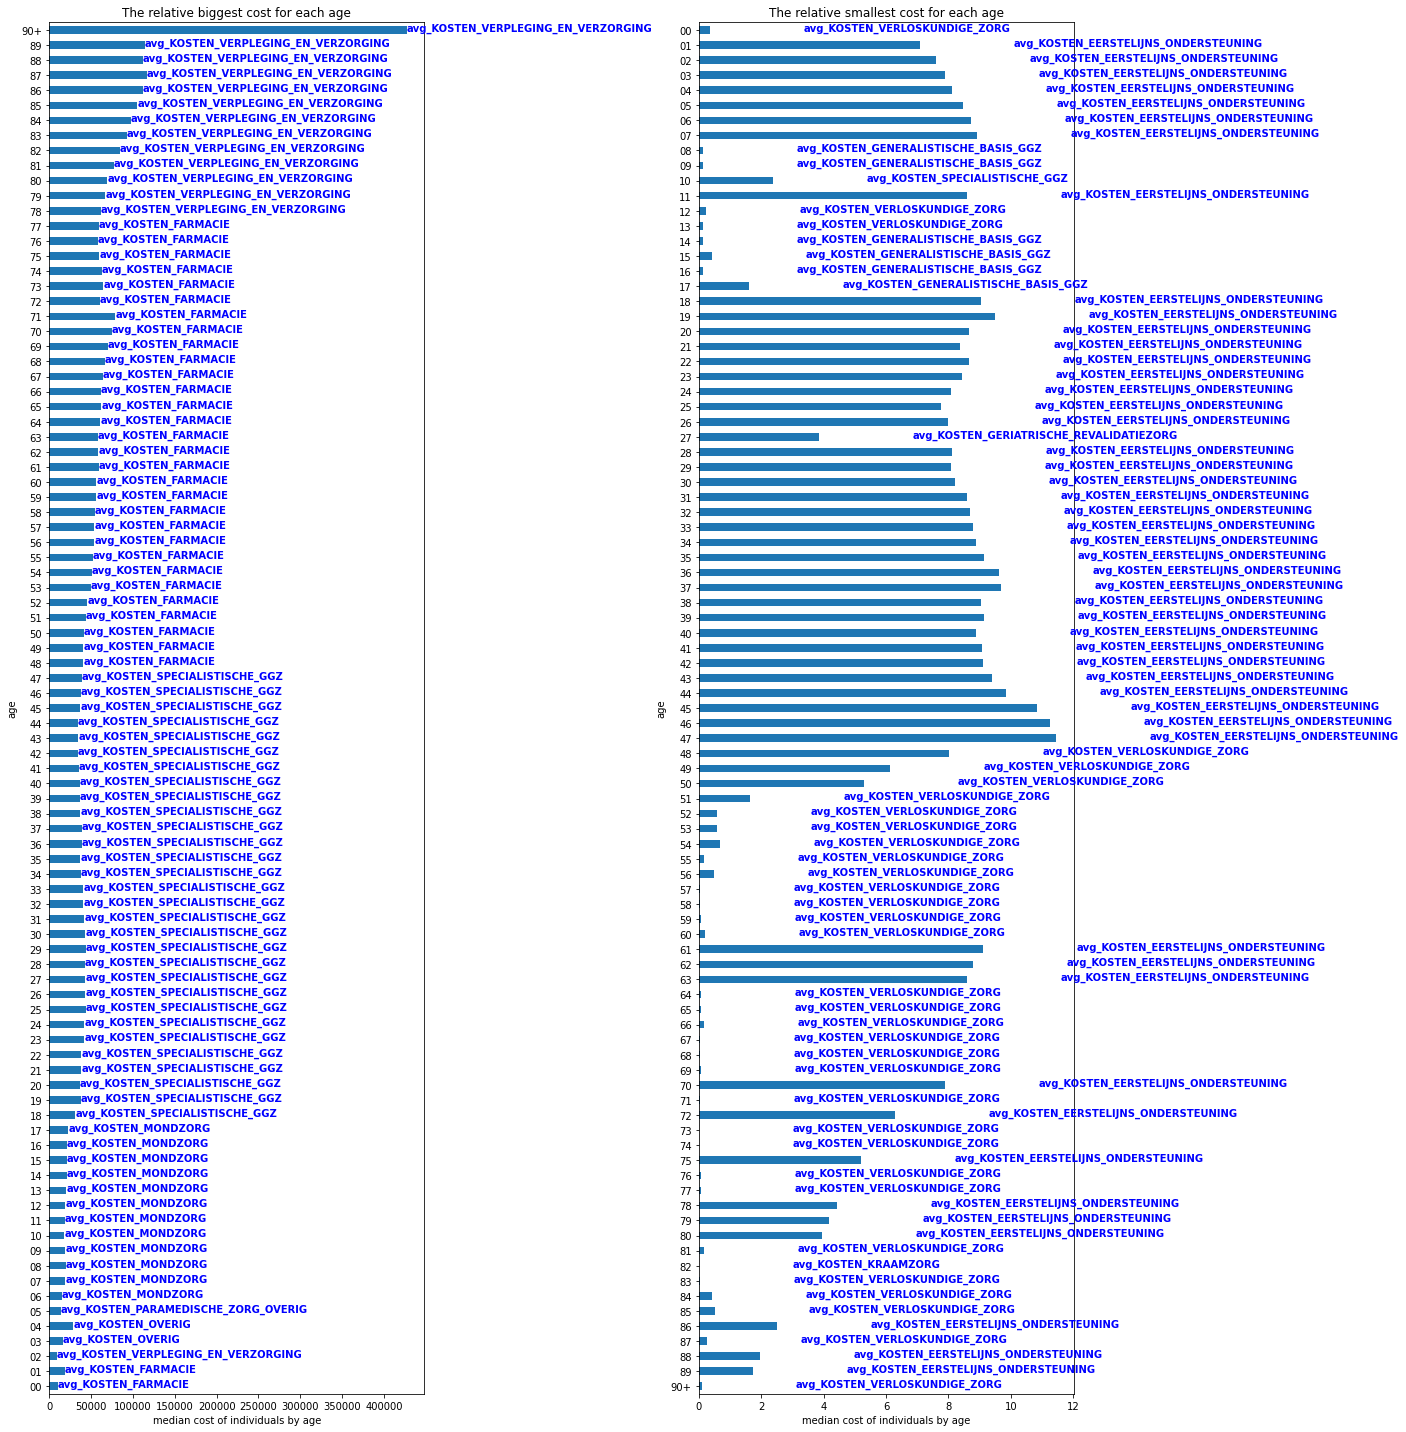

In [0]:
temp = get_temp(age_costs, 'all')
## uncomment below code to calculate only for male/females
# temp = get_temp(age_costs, 'male')
# temp = get_temp(age_costs, 'female')

plot_small_biggest(temp, 
                   'The relative biggest cost for each age',
                   'median cost of individuals by age',
                   'The relative smallest cost for each age',
                   'median cost of individuals by age',
                   temp.shape[0],'age',(20,20),'age','age')

### 4. On dividual level, what is more costy item for male/females? 

##### Findings:
Male and female more costy items are totally different. For details, check the plot.

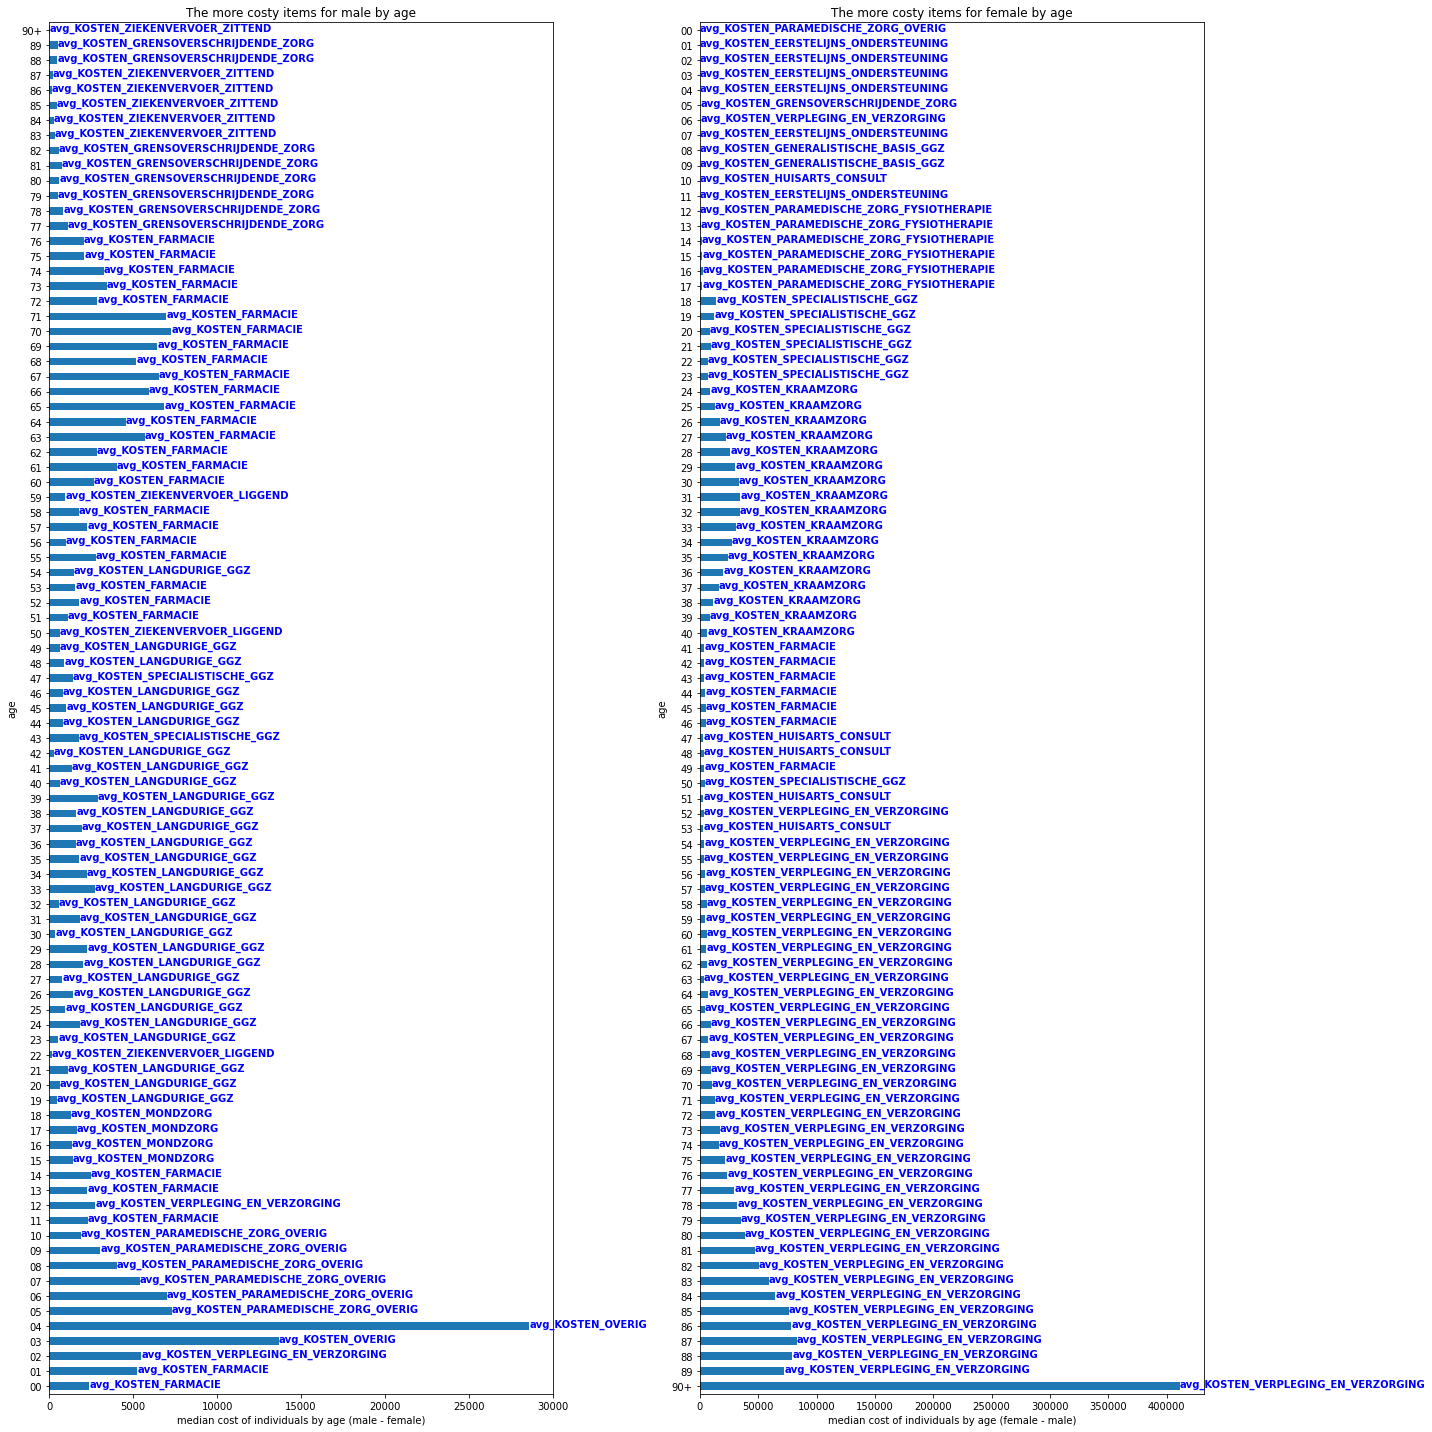

In [0]:
## what the biggest different cost between femal and male indivuals?

temp_M = age_costs[age_costs['GESLACHT'] == 'M'].drop(columns = {'GESLACHT'})
temp_F = age_costs[age_costs['GESLACHT'] == 'V'].drop(columns = {'GESLACHT'})
temp = temp_M.set_index('LEEFTIJDSKLASSE').subtract(temp_F.set_index('LEEFTIJDSKLASSE'), fill_value=0).reset_index()
temp = get_compares_df(temp, 'LEEFTIJDSKLASSE','age',['avg_KOSTEN_MEDISCH_SPECIALISTISCHE_ZORG']) 
temp.loc[temp['age'].str.len() ==1 , 'age'] = '0'+temp['age']

plot_small_biggest(temp, 
                   'The more costy items for male by age',
                   'median cost of individuals by age (male - female)',
                   'The more costy items for female by age',
                   'median cost of individuals by age (female - male)',
                   temp.shape[0],'age',(20,20),'age','age')

#### Geo plot for `MEDISCH_SPECIALISTISCHE` cost for each city.
since MEDISCH_SPECIALISTISCHE is the most costy item.

In [0]:
temp = insuer_gemeente.groupby(['GEMEENTENAAM','north_lng','north_lat'])['KOSTEN_MEDISCH_SPECIALISTISCHE_ZORG'].sum().reset_index()

In [0]:
gdf = GeoDataFrame(temp , geometry=points_from_xy(temp['north_lng'], temp['north_lat']))
Map([
    Layer(
        gdf,
        size_continuous_style('KOSTEN_MEDISCH_SPECIALISTISCHE_ZORG'),
        popup_hover=[
            popup_element('GEMEENTENAAM', title='GEMEENTENAAM'),
            popup_element('KOSTEN_MEDISCH_SPECIALISTISCHE_ZORG', title='MEDISCH_SPECIALISTISCHE')
        ]
    )]
)

For this dataset, feel free to try other questions..

## Rivm opendataset 

### Dataset explanation:
Datasets are collected from [rivm](https://statline.rivm.nl/).

This dataset contains 8 tables:
1. [blootstelling_aan_geluid_van_weg](https://statline.rivm.nl/portal.html?_la=nl&_catalog=RIVM&tableId=50066NED&_theme=71):
Blootstelling aan geluid van weg- en treinverkeer; wijken en buurten 2016
2. [gezondheid_per_wijk_en_buurt2016](https://statline.rivm.nl/portal.html?_la=nl&_catalog=RIVM&tableId=50052NED&_theme=72):
Gezondheid per wijk en buurt 2016
3. [kosten_van_ziekten2017_rivm](https://statline.rivm.nl/portal.html?_la=nl&_catalog=RIVM&tableId=50050NED&_theme=75):
Kosten van ziekten 2017
4. [overledenen](https://statline.rivm.nl/portal.html?_la=nl&_catalog=RIVM&tableId=50039NED&_theme=72):
Overledenen; doodsoorzaak (diagnose-indeling VTV), leeftijd, geslacht
5. [participatie](https://statline.rivm.nl/portal.html?_la=nl&_catalog=RIVM&tableId=50017NED&_theme=71):
Participatie; activiteiten, kenmerken personen 
6. [psychische_aandoeningen](https://statline.rivm.nl/portal.html?_la=nl&_catalog=RIVM&tableId=50025NED&_theme=72):
Psychische aandoeningen; type aandoening, persoonskenmerken
7. [rijksvaccinatieprogramma](https://statline.rivm.nl/portal.html?_la=nl&_catalog=RIVM&tableId=50055NED&_theme=73):
Rijksvaccinatieprogramma; soort vaccinatie, regio (indeling 2019)
8. [screening](https://statline.rivm.nl/portal.html?_la=nl&_catalog=RIVM&tableId=50029NED&_theme=73):
Screening; zwangeren en pasgeborenen, deelname, opsporing

In bigquery, dataset is named 'statline_rivm'. Table starts with 'metadata_' shows the meta data about the corresponding table. Table starts with 'combined_' combines meta data into the raw table. 


### Possible Research Questions:

- For `combined_kosten_van_ziekten2017_rivm` table:
  - preview the data
  - for Financieringsvorm (8,232,840 records):
    - For each Financieringsvorm, what the cost for different Zorgfunctie values? 
    - For each `Financieringsvorm`, what the sum/averaged cost for different `Leeftijd` value?
    - For each `Zirgfunctie`, what the sum/averaged cost for different `Leeftijd` values? 
    - For each age group, what the most/least costy diagnose?
    - For different `Zorgsector`, what sum/averaged cost for differe `Leeftijd` values?
    - For different `Financieringsvorm`, what sum/averaged cost for differe `*zorgsector*` values?
    - ect 

- For `combined_overledenen`:
  - Preview dataset
  - The total absolute/relative death amount over year?
  - Annually relative deaths for different age groups.
  - The top 10 `Doodsoorzaken` for each age group. 
  - Top 10 death causes (year 2017)
  - etc

- For table `combined_gezondheid_per_wijk_en_buurt2016`
  - Preview dataset
  - What the most severe areas in Enschede for problems, such as `Drinker_4`,`ZwareDrinker_5` 
  - etc

Feel free to try other tables.

### For `combined_kosten_van_ziekten2017_rivm` table:
#### Preview the data

In [0]:
q = '''
select *
from eci-workspace-rachel.statline_rivm.combined_kosten_van_ziekten2017_rivm 
limit 5
'''
bq_client.query(q).to_dataframe()

ID  TotaleKostenRIVM_3  KostenPerInwonerRIVM_4          Leeftijd                  Geslacht                                 Diagnose Zorgsector              Zorgfunctie                         Financieringsvorm
0  7479274                 0.0                     0.0    25 tot 45 jaar  Totaal mannen en vrouwen                           Longontsteking     Totaal          Langdurige zorg  Aanvullende verzekering & eigen betaling
1   825506                 NaN                     NaN      1 tot 5 jaar  Totaal mannen en vrouwen                            Dorsopathieën     Totaal  Beheer en administratie  Wet Langdurige Zorg excl. eigen bijdrage
2  4212256                 6.3                     5.0    55 tot 60 jaar  Totaal mannen en vrouwen                      Urine incontinentie     Totaal                   Totaal  Aanvullende verzekering & eigen betaling
3  7738456                 0.0                     0.0    45 tot 65 jaar  Totaal mannen en vrouwen                                 Cataract     Totaal          Langdurige zorg  Aanvullende verzekering & eigen betaling
4  8712050                 NaN                     NaN  85 jaar of ouder  Totaal mannen en vrouwen  Zweren van maag en twaalfvingerige darm     Totaal   Overig gezondheidszorg  Wet Langdurige Zorg excl. eigen bijdrage

#### For each Financieringsvorm, what the cost for different Zorgfunctie values? 

In [0]:
q = '''
select Financieringsvorm,Zorgfunctie,sum(TotaleKostenRIVM_3) as TotaleKostenRIVM_3,  sum(KostenPerInwonerRIVM_4) as KostenPerInwonerRIVM_4,
from eci-workspace-rachel.statline_rivm.combined_kosten_van_ziekten2017_rivm 
where Geslacht = 'Totaal mannen en vrouwen'
group by Financieringsvorm,Zorgfunctie
'''
temp = bq_client.query(q).to_dataframe().fillna(0)

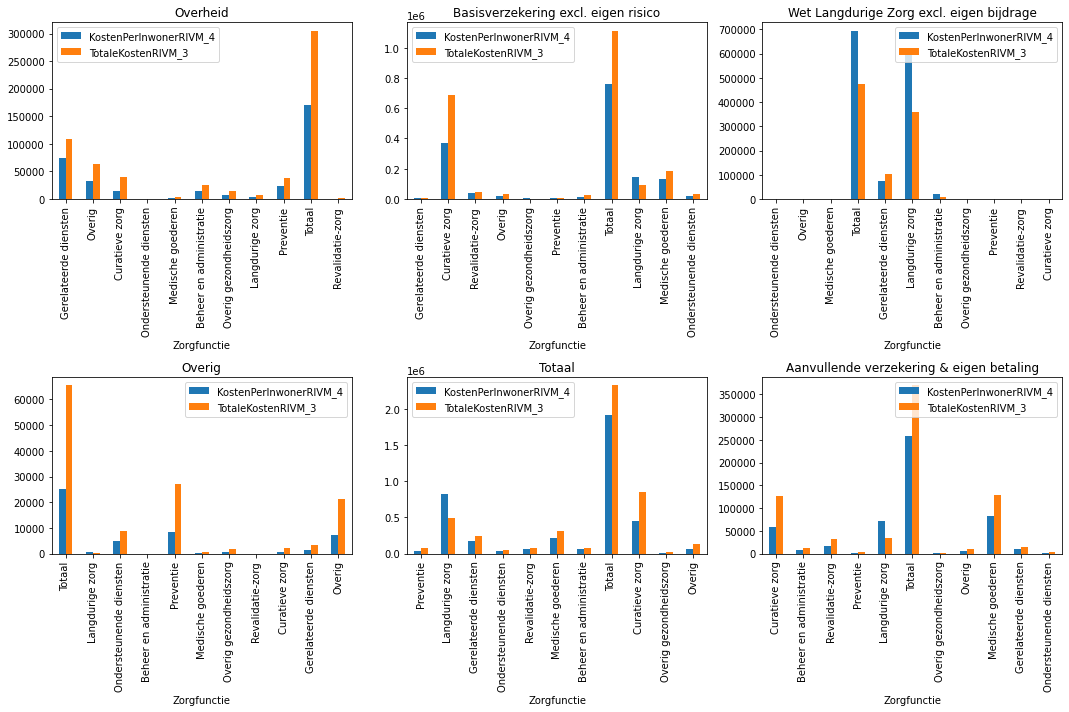

In [0]:
f, axes = plt.subplots(2, 3,figsize=(15,10))
F_list = temp['Financieringsvorm'].unique()
ax_list = [axes[0][0],axes[0][1],axes[0][2],axes[1][0],axes[1][1],axes[1][2]]
for idx,val in enumerate(F_list):
  temp[temp['Financieringsvorm'] == val].plot.bar(x='Zorgfunctie', y =['KostenPerInwonerRIVM_4','TotaleKostenRIVM_3'], title=val,ax = ax_list[idx])

f.tight_layout()

#### For each `Financieringsvorm`, what the sum/averaged cost for different `Leeftijd` value?

In [0]:
q = '''
select Financieringsvorm,Leeftijd,sum(TotaleKostenRIVM_3) as TotaleKostenRIVM_3,  sum(KostenPerInwonerRIVM_4) as KostenPerInwonerRIVM_4,
from eci-workspace-rachel.statline_rivm.combined_kosten_van_ziekten2017_rivm 
where Geslacht = 'Totaal mannen en vrouwen' and Leeftijd != 'Totaal'
group by Financieringsvorm,Leeftijd
'''
temp = bq_client.query(q).to_dataframe().fillna(0)

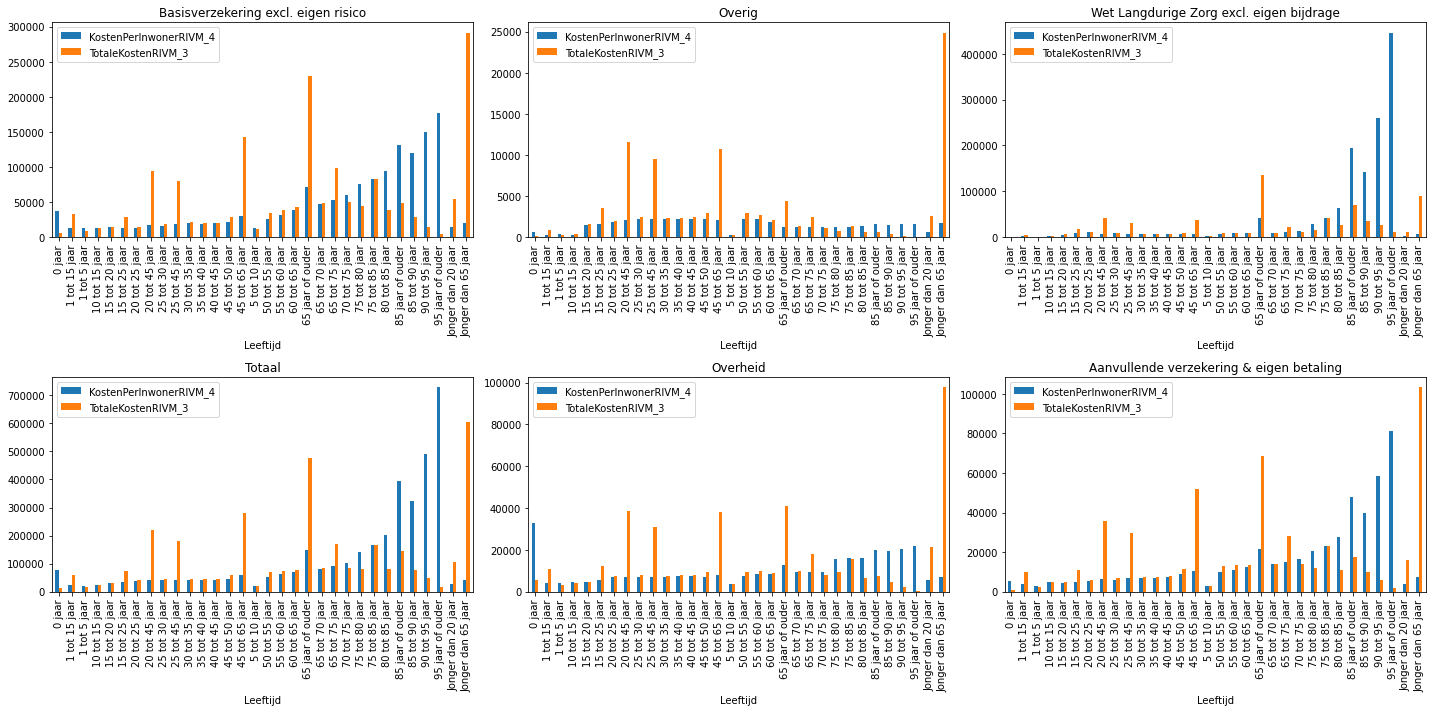

In [0]:
f, axes = plt.subplots(2, 3,figsize=(20,10))
F_list = temp['Financieringsvorm'].unique()
ax_list = [axes[0][0],axes[0][1],axes[0][2],axes[1][0],axes[1][1],axes[1][2]]
for idx,val in enumerate(F_list):
  temp[temp['Financieringsvorm'] == val].sort_values(by = ['Leeftijd']).plot.bar(x='Leeftijd', y =['KostenPerInwonerRIVM_4','TotaleKostenRIVM_3'], title=val,ax = ax_list[idx])

f.tight_layout()

#### For each `Zirgfunctie`, what the sum/averaged cost for different `Leeftijd` values? 

In [0]:
q = '''
select Zorgfunctie,Leeftijd,sum(TotaleKostenRIVM_3) as TotaleKostenRIVM_3,  sum(KostenPerInwonerRIVM_4) as KostenPerInwonerRIVM_4,
from eci-workspace-rachel.statline_rivm.combined_kosten_van_ziekten2017_rivm 
where Geslacht = 'Totaal mannen en vrouwen' and Leeftijd != 'Totaal'
group by Zorgfunctie,Leeftijd
'''
temp = bq_client.query(q).to_dataframe().fillna(0)

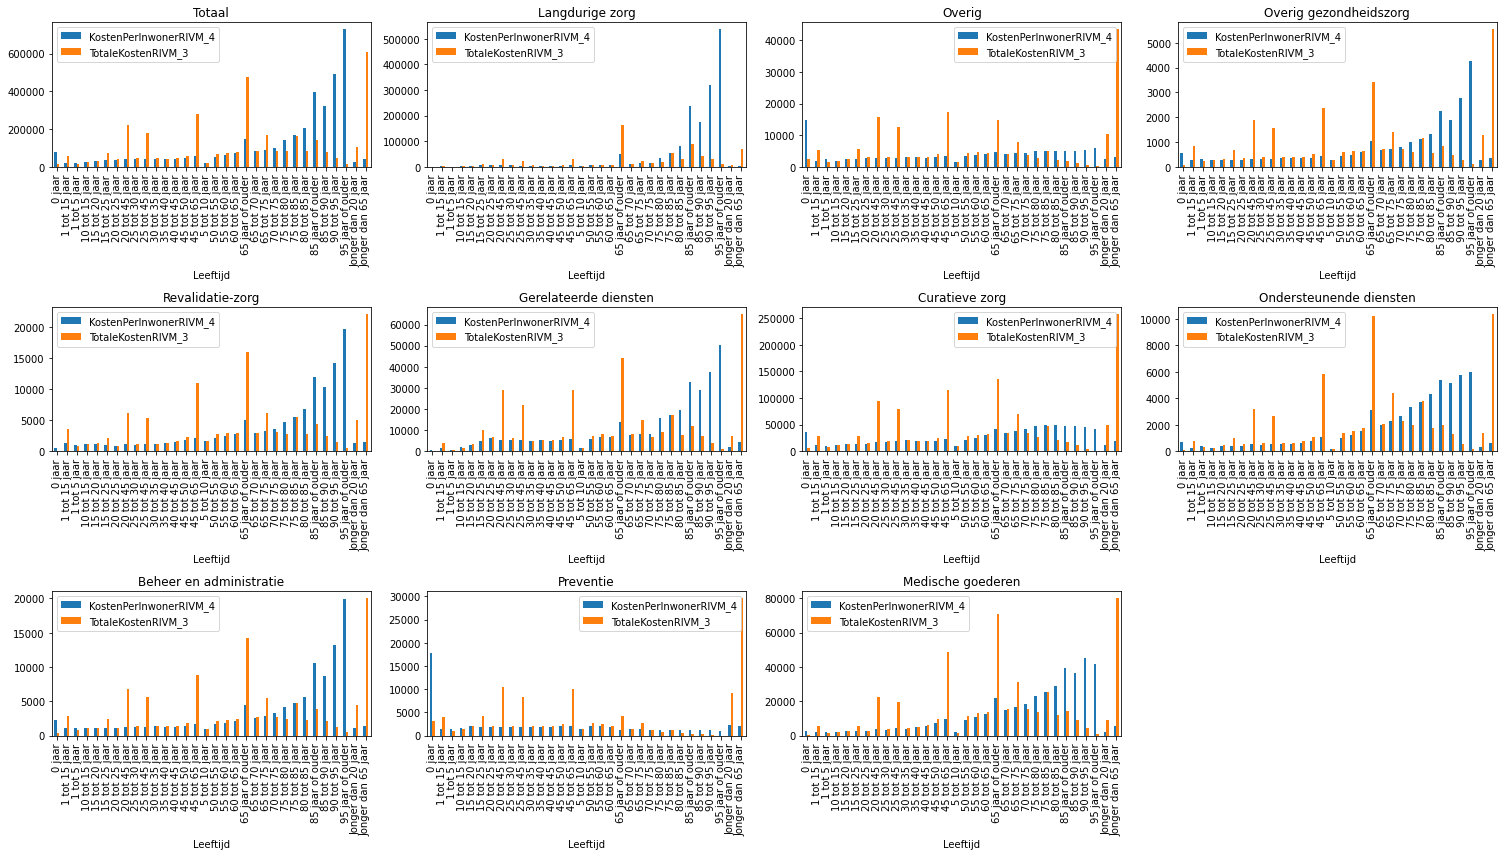

In [0]:
f, axes = plt.subplots(3, 4,figsize=(21,12))
F_list = temp['Zorgfunctie'].unique()
ax_list = [axes[0][0],axes[0][1],axes[0][2],axes[0][3],axes[1][0],axes[1][1],axes[1][2],axes[1][3],axes[2][0],axes[2][1],axes[2][2]]
for idx,val in enumerate(F_list):
  temp[temp['Zorgfunctie'] == val].sort_values(by = ['Leeftijd']).plot.bar(x='Leeftijd', y =['KostenPerInwonerRIVM_4','TotaleKostenRIVM_3'], title=val,ax = ax_list[idx])

f.delaxes(axes[2][3])
f.tight_layout()

#### For each age group, what the most/least costy diagnose?

In [0]:
q = '''
select Diagnose,Leeftijd,sum(TotaleKostenRIVM_3) as sum_TotaleKostenRIVM_3,  avg(KostenPerInwonerRIVM_4) as mean_KostenPerInwonerRIVM_4,
from eci-workspace-rachel.statline_rivm.combined_kosten_van_ziekten2017_rivm 
where Geslacht = 'Totaal mannen en vrouwen'
group by Diagnose,Leeftijd
'''
temp = bq_client.query(q).to_dataframe()

In [0]:
max_sum_TotaleKostenRIVM_3 = pd.merge(temp, 
                                      temp.groupby(['Leeftijd'])['sum_TotaleKostenRIVM_3']\
                                          .agg(['max'])\
                                          .rename(columns ={'max':'sum_TotaleKostenRIVM_3'})\
                                          .reset_index(), 
                                      on = ['sum_TotaleKostenRIVM_3','Leeftijd'], 
                                      how= 'inner')[['sum_TotaleKostenRIVM_3','Leeftijd','Diagnose']]

max_mean_KostenPerInwonerRIVM_4 = pd.merge(temp, 
                                      temp.dropna(axis=1,how="all").groupby(['Leeftijd'])['mean_KostenPerInwonerRIVM_4']\
                                          .agg(['max'])\
                                          .rename(columns ={'max':'mean_KostenPerInwonerRIVM_4'})\
                                          .reset_index(), 
                                      on = ['mean_KostenPerInwonerRIVM_4','Leeftijd'], 
                                      how= 'inner')[['mean_KostenPerInwonerRIVM_4','Leeftijd','Diagnose']]

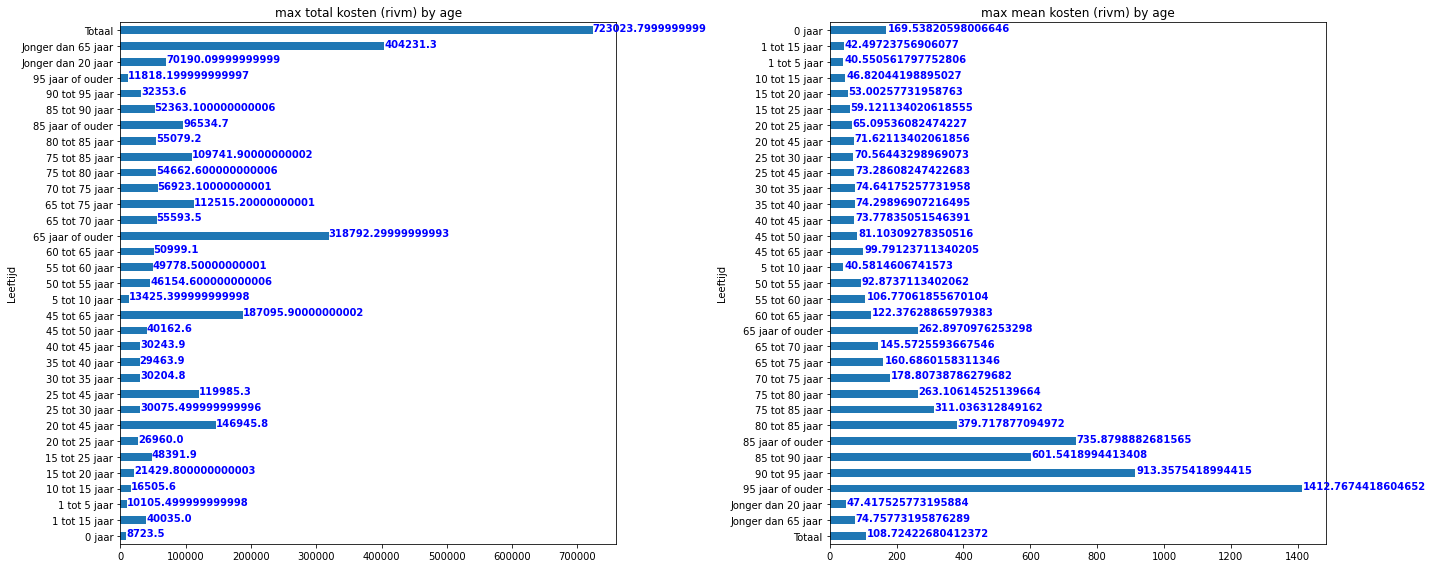

In [0]:
f, axes = plt.subplots(1, 2,figsize=(20,8))
top_10 = max_sum_TotaleKostenRIVM_3.sort_values(by ='Leeftijd')
top_10.plot.barh(x='Leeftijd', y='sum_TotaleKostenRIVM_3', legend=False, title= 'max total kosten (rivm) by age', ax=axes[0])
big_vals = top_10['sum_TotaleKostenRIVM_3'].values.tolist()
for i, v in enumerate(top_10['sum_TotaleKostenRIVM_3'].values.tolist()):
    axes[0].text(big_vals[i]+3, i-.05, str(v), color='blue', fontweight='bold')

top_10_s = max_mean_KostenPerInwonerRIVM_4.sort_values(by = 'Leeftijd' ,ascending=False)
top_10_s.plot.barh(x='Leeftijd', y='mean_KostenPerInwonerRIVM_4',legend=False, title= 'max mean kosten (rivm) by age',ax=axes[1])
big_vals = top_10_s['mean_KostenPerInwonerRIVM_4'].values.tolist()
for i, v in enumerate(top_10_s['mean_KostenPerInwonerRIVM_4'].values.tolist()):
    axes[1].text(big_vals[i]+3, i-.05, str(v), color='blue', fontweight='bold')

f.tight_layout()

In [0]:
## there are multiple Diagnoses equals to 0 for age groups
zero_kosten_diagnose = temp[temp['sum_TotaleKostenRIVM_3'] == 0]
zero_kosten_diagnose

Diagnose            Leeftijd  sum_TotaleKostenRIVM_3  mean_KostenPerInwonerRIVM_4
2                                  Blaaskanker      15 tot 20 jaar                     0.0                     0.000000
24                                Schizofrenie        1 tot 5 jaar                     0.0                     0.000000
31                                  Maagkanker        1 tot 5 jaar                     0.0                     0.000000
41                    Diabetische retinopathie       5 tot 10 jaar                     0.0                     0.000000
45                        Non-Hodgkin lymfomen       5 tot 10 jaar                     0.0                     0.000000
58                        Baarmoederhalskanker              0 jaar                     0.0                     0.000000
60                        Baarmoederhalskanker    95 jaar of ouder                     0.0                     0.000000
63                              Slokdarmkanker        1 tot 5 jaar                     0.0                     0.000000
69                     Non-melanoma huidkanker       1 tot 15 jaar                     0.0                     0.000000
72                                Appendicitis    95 jaar of ouder                     0.0                     0.076923
75                          Ziekte van Hodgkin      90 tot 95 jaar                     0.0                     0.000000
89                        Overige leverziekten      25 tot 30 jaar                     0.0                     0.000000
95                          Schildklierziekten       5 tot 10 jaar                     0.0                     0.000000
107                           Weke delen reuma              0 jaar                     0.0                     0.000000
133                                   Kraambed    85 jaar of ouder                     0.0                     0.000000
142                Hyperplasie van de prostaat        1 tot 5 jaar                     0.0                     0.000000
155                   Fertiliteitsproblematiek    95 jaar of ouder                     0.0                     0.000000
161                                Hemorroïden    95 jaar of ouder                     0.0                     0.210000
173                             Vroeggeboorten      40 tot 45 jaar                     0.0                     0.000000
196                                   Burn-out        1 tot 5 jaar                     0.0                     0.000000
206                       Overige leverziekten      30 tot 35 jaar                     0.0                     0.000000
211                                  Bevalling      70 tot 75 jaar                     0.0                     0.000000
217                         Ziekte van Hodgkin        1 tot 5 jaar                     0.0                     0.000000
222                                Blaaskanker      10 tot 15 jaar                     0.0                     0.000000
242                                   Burn-out      90 tot 95 jaar                     0.0                     0.000000
251                                  Bevalling      65 tot 75 jaar                     0.0                     0.000000
291                                Hemorroïden              0 jaar                     0.0                     0.000000
302                               Appendicitis              0 jaar                     0.0                     0.000000
316        Aangeboren afwijkingen zenuwstelsel      90 tot 95 jaar                     0.0                     0.000000
325                                   Burn-out    95 jaar of ouder                     0.0                     0.082192
349        Aangeboren afwijkingen zenuwstelsel    85 jaar of ouder                     0.0                     0.000000
385                                Osteoporose      10 tot 15 jaar                     0.0                     0.000000
400      Nierkanker (excl. tumoren nierbekken)    95 jaar of ouder            

Text(0, 0.5, 'count')

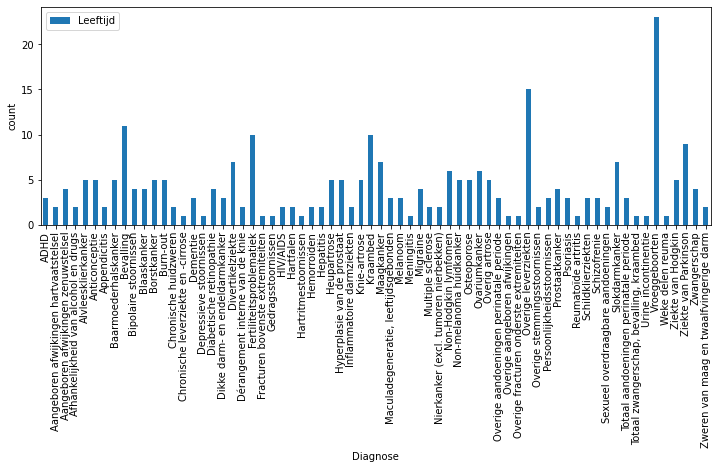

In [0]:
## the most zero cost Diagnoses 
ax = zero_kosten_diagnose.groupby(['Diagnose']).count().reset_index().plot.bar(x='Diagnose', y='Leeftijd',figsize=(12,4))
ax.set_ylabel('count')

#### For different `Zorgsector`, what sum/averaged cost for differe `Leeftijd` values?

In [0]:
q = '''
select Zorgsector,Leeftijd,sum(TotaleKostenRIVM_3) as sum_TotaleKostenRIVM_3,  avg(KostenPerInwonerRIVM_4) as mean_KostenPerInwonerRIVM_4,
from eci-workspace-rachel.statline_rivm.combined_kosten_van_ziekten2017_rivm 
where Geslacht = 'Totaal mannen en vrouwen'
group by Zorgsector,Leeftijd
'''
temp = bq_client.query(q).to_dataframe()

In [0]:
temp_above_zero = temp[(temp['sum_TotaleKostenRIVM_3'] > 0) & (temp['Leeftijd'] != 'Totaal')]

len(temp_above_zero['Zorgsector'].unique())

23

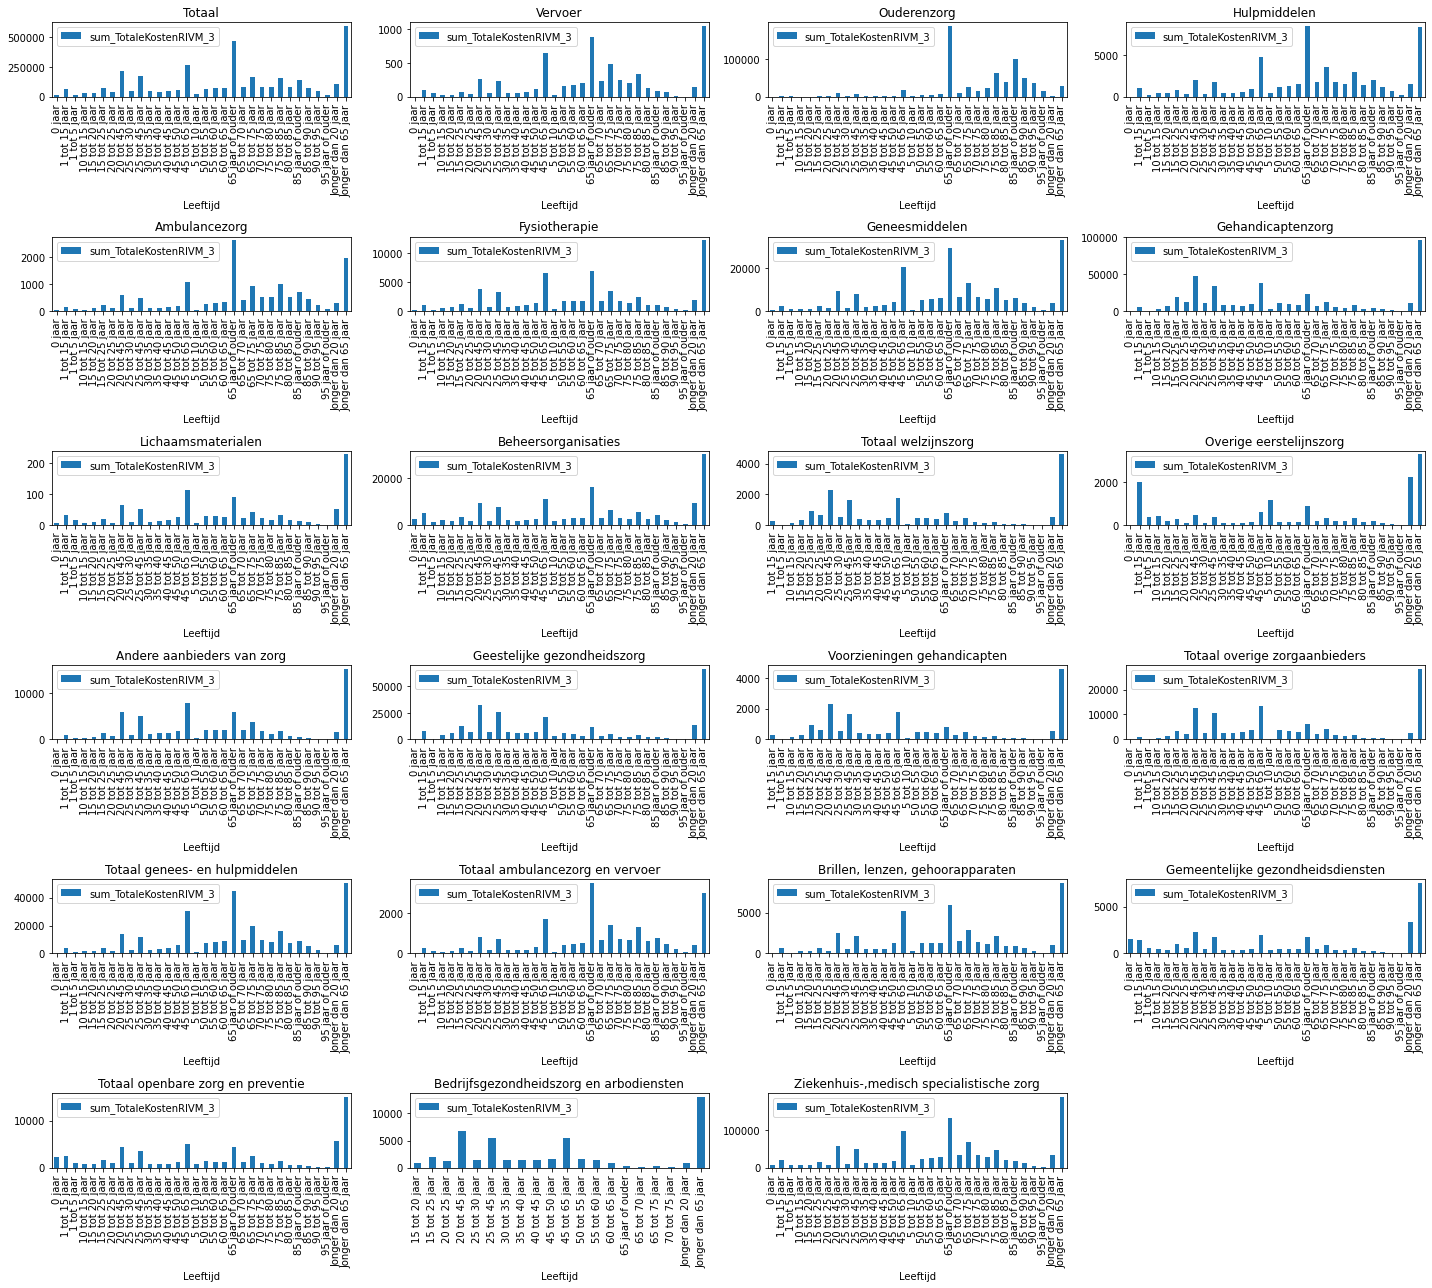

In [0]:
## sum cost
f, axes = plt.subplots(6, 4,figsize=(20,18))

F_list = temp_above_zero['Zorgsector'].unique()
ax_list = [axes[0][0],axes[0][1],axes[0][2],axes[0][3],
           axes[1][0],axes[1][1],axes[1][2],axes[1][3],
           axes[2][0],axes[2][1],axes[2][2],axes[2][3],
           axes[3][0],axes[3][1],axes[3][2],axes[3][3],
           axes[4][0],axes[4][1],axes[4][2],axes[4][3],
           axes[5][0],axes[5][1],axes[5][2]]
for idx,val in enumerate(F_list):
  temp_above_zero[temp_above_zero['Zorgsector'] == val].sort_values(by = ['Leeftijd'])\
                                                        .plot.bar(x='Leeftijd', 
                                                                  y ='sum_TotaleKostenRIVM_3', 
                                                                  title=val,ax = ax_list[idx])

f.delaxes(axes[5][3])
f.tight_layout()


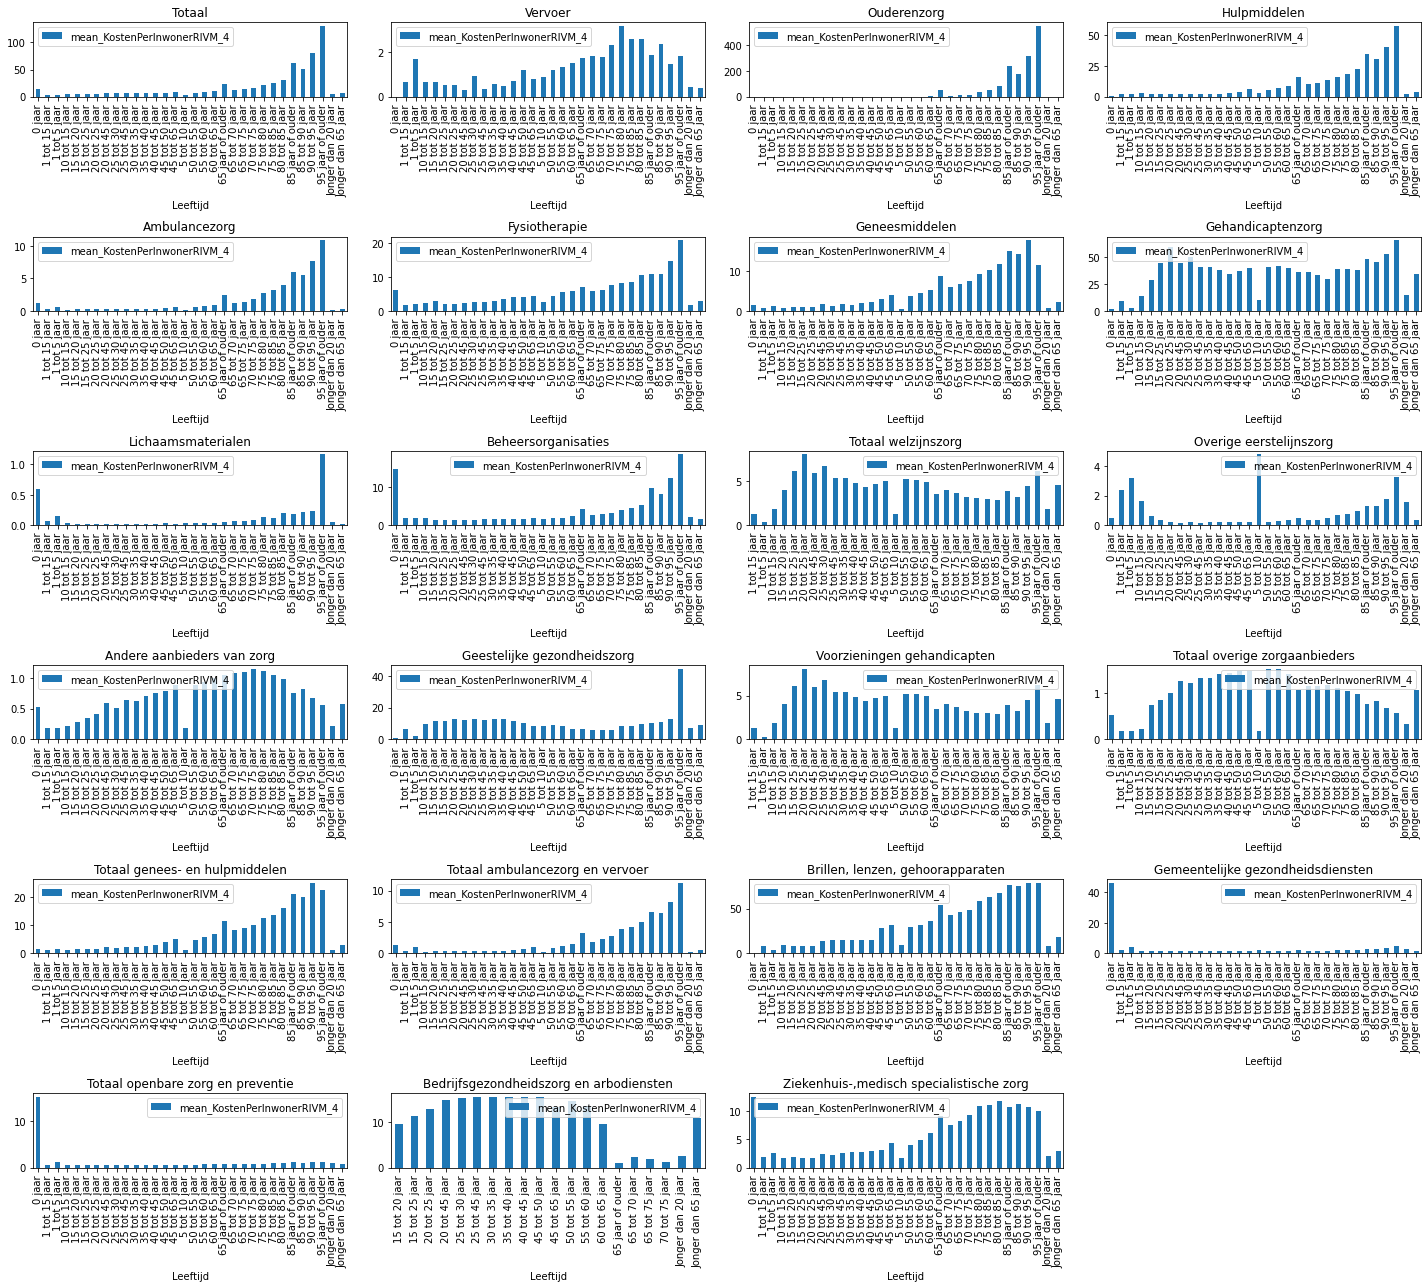

In [0]:
## averaged cost
f, axes = plt.subplots(6, 4,figsize=(20,18))

F_list = temp_above_zero['Zorgsector'].unique()
ax_list = [axes[0][0],axes[0][1],axes[0][2],axes[0][3],
           axes[1][0],axes[1][1],axes[1][2],axes[1][3],
           axes[2][0],axes[2][1],axes[2][2],axes[2][3],
           axes[3][0],axes[3][1],axes[3][2],axes[3][3],
           axes[4][0],axes[4][1],axes[4][2],axes[4][3],
           axes[5][0],axes[5][1],axes[5][2]]
for idx,val in enumerate(F_list):
  temp_above_zero[temp_above_zero['Zorgsector'] == val].sort_values(by = ['Leeftijd'])\
                                                        .plot.bar(x='Leeftijd', 
                                                                  y ='mean_KostenPerInwonerRIVM_4', 
                                                                  title=val,ax = ax_list[idx])

f.delaxes(axes[5][3])
f.tight_layout()


#### For different `Financieringsvorm`, what sum/averaged cost for differe `*zorgsector*` values?

In [0]:
q = '''
select Zorgsector,Financieringsvorm,sum(TotaleKostenRIVM_3) as sum_TotaleKostenRIVM_3,  avg(KostenPerInwonerRIVM_4) as mean_KostenPerInwonerRIVM_4,
from eci-workspace-rachel.statline_rivm.combined_kosten_van_ziekten2017_rivm 
where Geslacht = 'Totaal mannen en vrouwen' and Zorgsector != 'Totaal'
group by Zorgsector,Financieringsvorm
'''
temp = bq_client.query(q).to_dataframe()

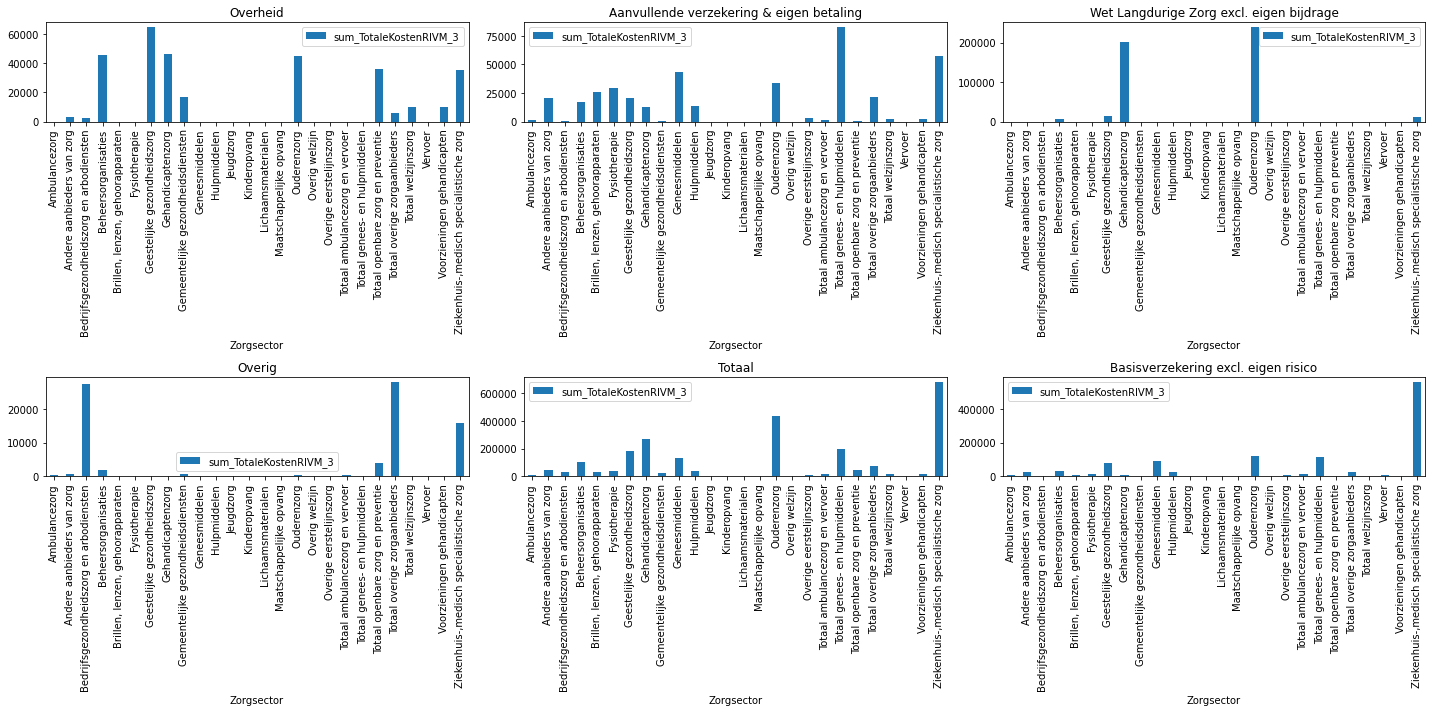

In [0]:
f, axes = plt.subplots(2, 3,figsize=(20,10))
F_list = temp['Financieringsvorm'].unique()
ax_list = [axes[0][0],axes[0][1],axes[0][2],axes[1][0],axes[1][1],axes[1][2]]
for idx,val in enumerate(F_list):
  temp[temp['Financieringsvorm'] == val].sort_values(by = ['Zorgsector'])\
                                        .plot.bar(x='Zorgsector', 
                                                  y ='sum_TotaleKostenRIVM_3', 
                                                  title=val,
                                                  ax = ax_list[idx])

f.tight_layout()

### For `combined_overledenen`:
#### Preview dataset

In [0]:
q = '''
select *
from eci-workspace-rachel.statline_rivm.combined_overledenen
limit 5
'''
bq_client.query(q).to_dataframe()

ID  Overledenen_1  OverledenenRelatief_2                Leeftijd Geslacht                       Doodsoorzaken Perioden
0  129812        38899.0                 771.65  Totaal alle leeftijden   Mannen  Totaal onderliggende doodsoorzaken     1950
1  129813        40083.0                 783.67  Totaal alle leeftijden   Mannen  Totaal onderliggende doodsoorzaken     1951
2  129814        39240.0                 758.71  Totaal alle leeftijden   Mannen  Totaal onderliggende doodsoorzaken     1952
3  129815        41871.0                 801.04  Totaal alle leeftijden   Mannen  Totaal onderliggende doodsoorzaken     1953
4  129816        41755.0                 789.55  Totaal alle leeftijden   Mannen  Totaal onderliggende doodsoorzaken     1954

#### the total absolute/relative death amount over year?

The over death increase year by year, but the relative death decrease. 


In [0]:
# q = '''
# select *
# from eci-workspace-rachel.statline_rivm.combined_overledenen
# where Leeftijd = 'Totaal alle leeftijden' and Doodsoorzaken = 'Totaal onderliggende doodsoorzaken' and Geslacht = 'Totaal mannen en vrouwen'
# '''
q = '''
select Perioden, sum(Overledenen_1) as Overledenen_1, sum(OverledenenRelatief_2) as OverledenenRelatief_2
from eci-workspace-rachel.statline_rivm.combined_overledenen
where Leeftijd not in ('Totaal alle leeftijden','Gestandaardiseerde leeftijd totaal 2010') and Doodsoorzaken = 'Totaal onderliggende doodsoorzaken' and Geslacht = 'Totaal mannen en vrouwen'
group by Perioden
'''

temp = bq_client.query(q).to_dataframe()

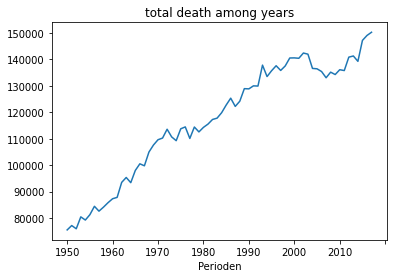

In [0]:
temp.plot.line(x='Perioden', y='Overledenen_1',title='total death among years', legend = False)

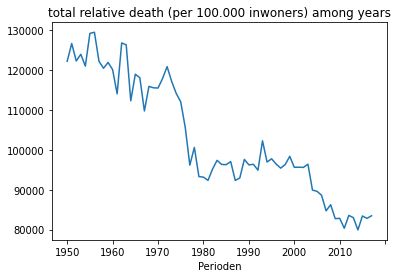

In [0]:
temp.plot.line(x='Perioden', y='OverledenenRelatief_2',title='total relative death (per 100.000 inwoners) among years', legend = False)

In [0]:
q = '''
select Leeftijd,Perioden, sum(Overledenen_1) as Overledenen_1, sum(OverledenenRelatief_2) as OverledenenRelatief_2
from eci-workspace-rachel.statline_rivm.combined_overledenen
where Leeftijd not in ('Totaal alle leeftijden','Gestandaardiseerde leeftijd totaal 2010') and Doodsoorzaken = 'Totaal onderliggende doodsoorzaken' and Geslacht = 'Totaal mannen en vrouwen'
group by Leeftijd,Perioden
'''
temp = bq_client.query(q).to_dataframe()

In [0]:
len(temp['Leeftijd'].unique())

21

#### Annually relative deaths for different age groups.
- More death for olders. 
- youngers relative death smoonthly decrease year by year. 
- olders relative death also decarese in the trend, although some years increse a bit.

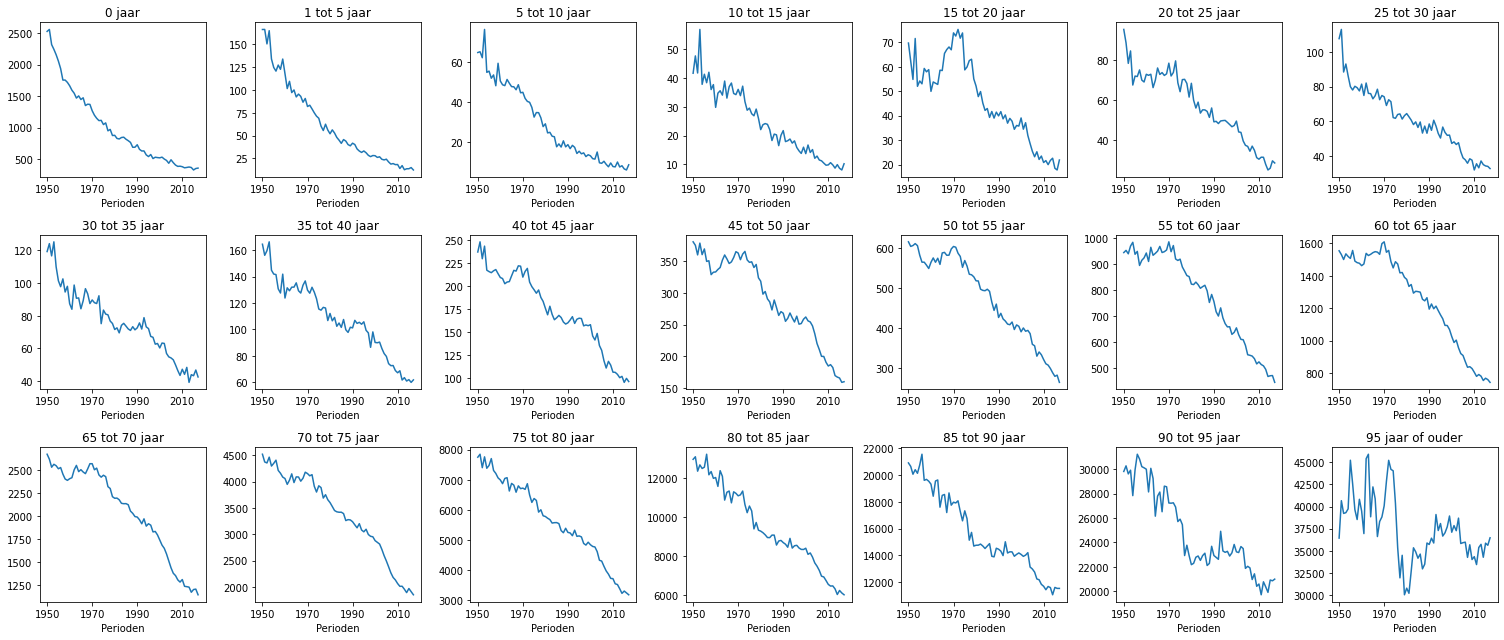

In [0]:
f, axes = plt.subplots(3,7,figsize=(21,9))
F_list = temp['Leeftijd'].unique()
ax_list = [axes[0][0],axes[0][1],axes[0][2],axes[0][3],axes[0][4],axes[0][5],axes[0][6],
          axes[1][0],axes[1][1],axes[1][2],axes[1][3],axes[1][4],axes[1][5],axes[1][6],
          axes[2][0],axes[2][1],axes[2][2],axes[2][3],axes[2][4],axes[2][5],axes[2][6]]
for idx,val in enumerate(F_list):
  temp[temp['Leeftijd'] == val].sort_values(by = ['Perioden'])\
                                        .plot.line(x='Perioden', 
                                                  y ='OverledenenRelatief_2', 
                                                  title=val,
                                                  ax = ax_list[idx],
                                                   legend = False)

f.tight_layout()

In [0]:
## for different age, the Doodsoorzaken? 
q = '''
select Leeftijd,Doodsoorzaken, avg(Overledenen_1) as avg_Overledenen_1, avg(OverledenenRelatief_2) as avg_OverledenenRelatief_2

from eci-workspace-rachel.statline_rivm.combined_overledenen

where Leeftijd not in ('Totaal alle leeftijden','Gestandaardiseerde leeftijd totaal 2010') AND 
Doodsoorzaken != 'Totaal onderliggende doodsoorzaken' AND 
Geslacht = 'Totaal mannen en vrouwen'

group by Leeftijd,Doodsoorzaken
'''
temp = bq_client.query(q).to_dataframe()


In [0]:
len(temp['Leeftijd'].unique())

21

####  The top 10 `Doodsoorzaken` for each age group. 

Averaged over years (from 1950 to 2017) the relative death amount (per 100,000 inhabits). 

There are some consisteny among age groups (s.t elderly groups share similar characteristics) .

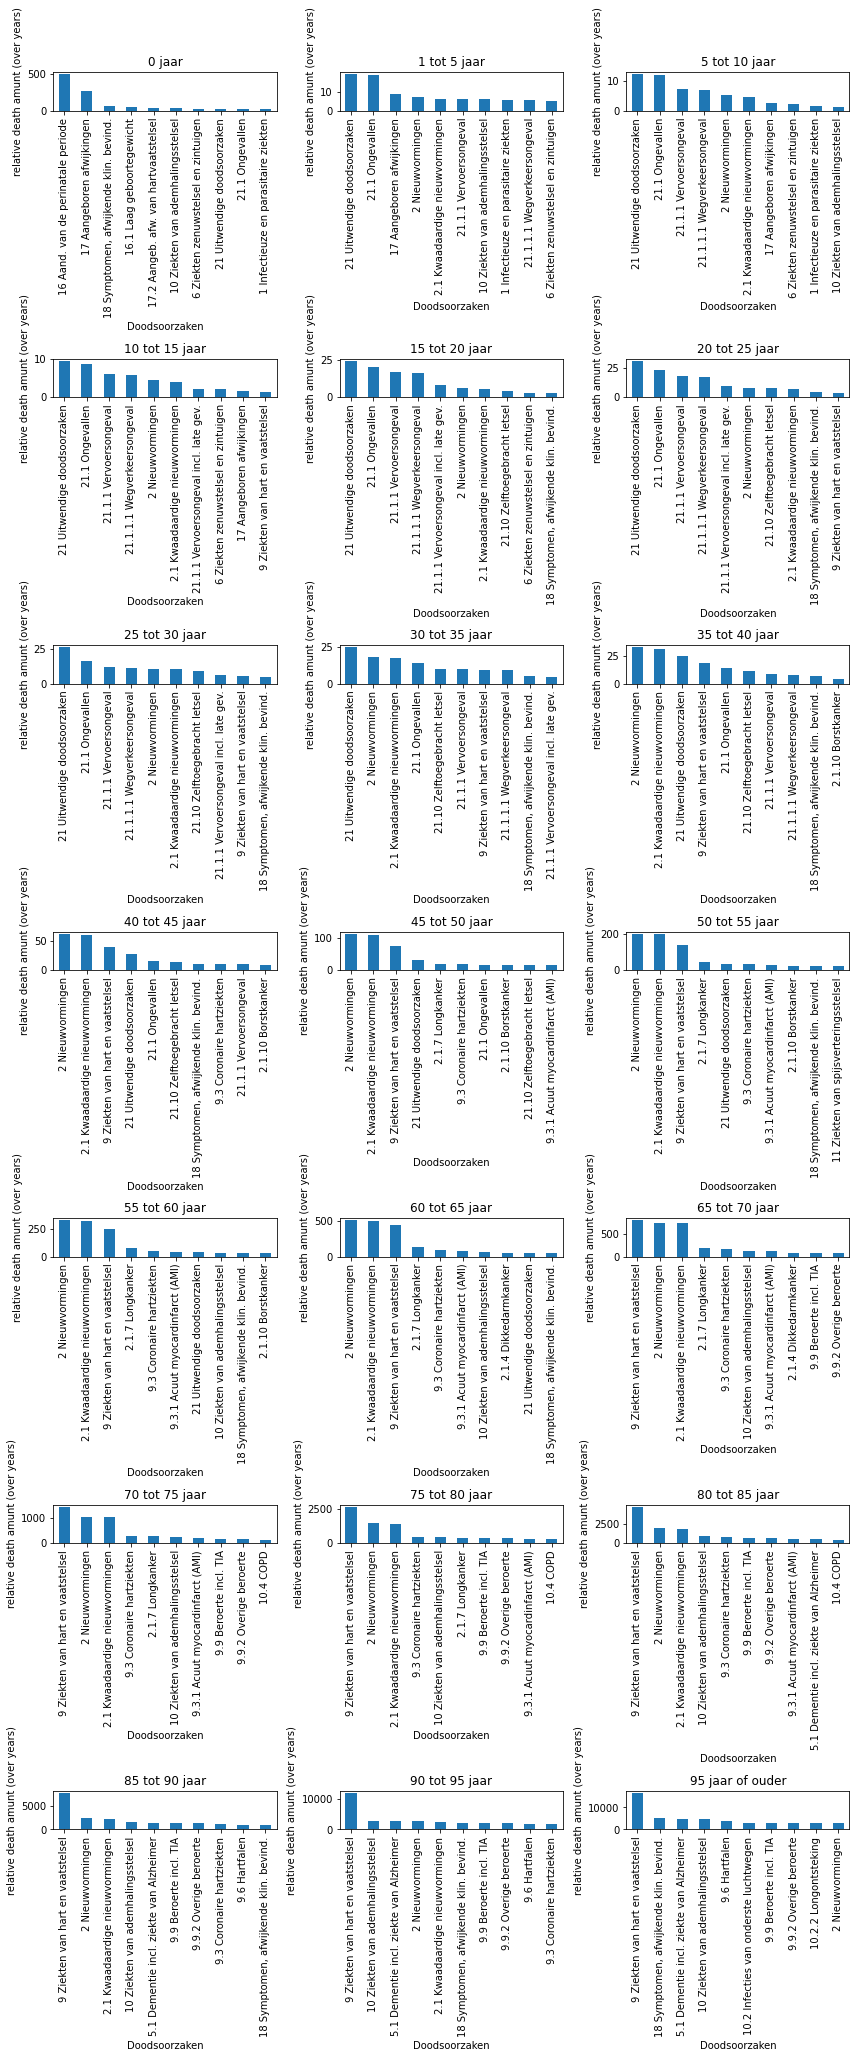

In [0]:
f, axes = plt.subplots(7,3,figsize=(12,28))
F_list = temp['Leeftijd'].unique()
ax_list = [axes[0][0],axes[0][1],axes[0][2],
           axes[1][0],axes[1][1],axes[1][2],
           axes[2][0],axes[2][1],axes[2][2],
           axes[3][0],axes[3][1],axes[3][2],
           axes[4][0],axes[4][1],axes[4][2],
           axes[5][0],axes[5][1],axes[5][2],
           axes[6][0],axes[6][1],axes[6][2]]

## the top 10 Doodsoorzaken for each age group 
for idx,val in enumerate(F_list):
  temp[temp['Leeftijd'] == val].sort_values(by = ['avg_OverledenenRelatief_2'],ascending = False).head(10)\
                                        .plot.bar(x='Doodsoorzaken', 
                                                  y ='avg_OverledenenRelatief_2', 
                                                  title=val,
                                                  ax = ax_list[idx],
                                                  legend = False)
  ax_list[idx].set_ylabel('relative death amunt (over years)')

f.tight_layout()

In [0]:
#### for women and male, the top 10 deadly causes? 
## for different age, the Doodsoorzaken? 
q = '''
select Doodsoorzaken, sum(Overledenen_1) as sum_Overledenen_1, sum(OverledenenRelatief_2) as sum_OverledenenRelatief_2

from eci-workspace-rachel.statline_rivm.combined_overledenen

where Leeftijd not in ('Totaal alle leeftijden','Gestandaardiseerde leeftijd totaal 2010') AND 
Doodsoorzaken != 'Totaal onderliggende doodsoorzaken' AND 
Geslacht = 'Totaal mannen en vrouwen' AND 
Perioden = '2017'

group by Doodsoorzaken
'''
temp = bq_client.query(q).to_dataframe()

#### Top 10 death causes (year 2017)

The left plot shows for the sum of absolute death amount. The right shows for the sum of relative death (per 100,000 inhabits) amount. Interestingly, the top 10 death cases are slightly differet. 

Text(0, 0.5, 'averaged relative death')

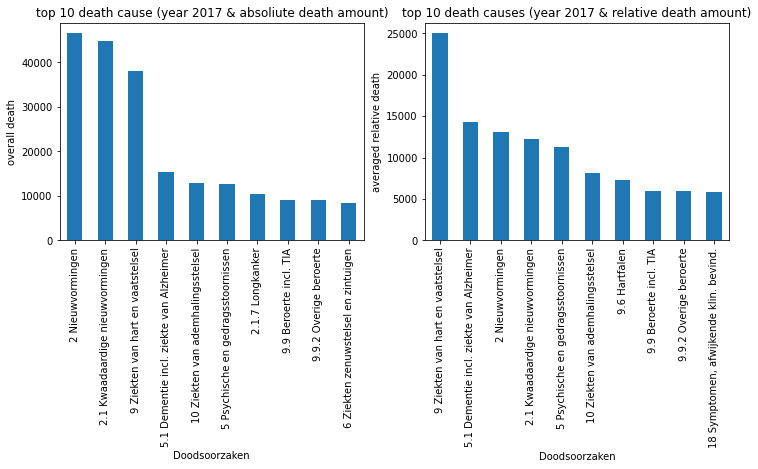

In [0]:

f, axes = plt.subplots(1, 2,figsize=(12,4))

temp.sort_values(by = ['sum_Overledenen_1'], ascending = False)\
          .head(10).plot.bar(x = 'Doodsoorzaken', 
                             y = 'sum_Overledenen_1', 
                             legend = False, 
                             title='top 10 death cause (year 2017 & absoliute death amount)',
                             ax = axes[0])
axes[0].set_ylabel('overall death')

temp.sort_values(by = ['sum_OverledenenRelatief_2'], ascending = False)\
        .head(10).plot.bar(x = 'Doodsoorzaken', 
                           y = 'sum_OverledenenRelatief_2', 
                           legend = False, 
                           title='top 10 death causes (year 2017 & relative death amount)',
                           ax = axes[1])
        
axes[1].set_ylabel('averaged relative death')

### For table `combined_gezondheid_per_wijk_en_buurt2016`
#### Preview

In [0]:
q = '''
select *
from eci-workspace-rachel.statline_rivm.combined_gezondheid_per_wijk_en_buurt2016
WHERE RAND() < 1/100 and Drinker_4 is not null
limit 5
'''
bq_client.query(q).to_dataframe()

ID                            Gemeentenaam_1 SoortRegio_2  Codering_3  Drinker_4  ZwareDrinker_5  OvermatigeDrinker_6  VoldoetAanAlcoholrichtlijn_7  Overgewicht_8  Obesitas_9  Roker_10  LangdurigeZiekteOfAandoening_11  BeperktVanwegeGezondheid_12  ErnstigBeperktVanwegeGezondheid_13  LangdurigeZiekteEnBeperkt_14  Gehoorbeperking_15  Gezichtsbeperking_16  Mobiliteitsbeperking_17  MinstensEenBeperking_18  MatigHoogRisicoOpAngstOfDepressie_19  HoogRisicoOpAngstOfDepressie_20  Eenzaam_21  ErnstigZeerErnstigEenzaam_22  GoedZeerGoedErvarenGezondheid_23  Sporter_24  VoldoetAanBeweegrichtlijn_25  MatigVeelRegieOverEigenLeven_26  MoeiteMetRondkomen_27  Vrijwilligerswerk_28  Mantelzorger_29  MantelzorgOntvangenAfg12Mnd65_30  MantelzorgOntvangenNu65_31               WijkenEnBuurten          Leeftijd
0  38960  Haren                                        Buurt     BU00170108       80.0             4.0                  7.0                          49.0           49.0        11.0       9.0                             44.0                         44.0                                 5.0                          31.0                 8.0                   5.0                     14.0                     20.0                                  30.0                              2.0        41.0                           6.0                              73.0        36.0                          45.0                             88.0                    8.0                  36.0             18.0                              10.0                         7.0  Verspreide huizen Onner Esch  65 jaar of ouder
1  39098  Heerenveen                                   Buurt     BU00740302       78.0             5.0                  6.0                          49.0           56.0        14.0      11.0                             45.0                         46.0                                 6.0                          34.0                 9.0                   4.0                     17.0                     23.0                                  34.0                              2.0        46.0                           6.0                              69.0        31.0                          36.0                             88.0                    9.0                  35.0             14.0                              12.0                        10.0                      Bontebok  65 jaar of ouder
2  41993  De Marne                                     Buurt     BU16630106       74.0             7.0                  9.0                          51.0           64.0        26.0      18.0                             49.0                         53.0                                 7.0                          37.0                 7.0                  12.0                     18.0                     30.0                                  31.0                              2.0        47.0                           8.0                              65.0        23.0                          28.0                             88.0                   16.0                  37.0             12.0                              17.0                        13.0                      Zuurdijk  65 jaar of ouder
3  42020  Marum                                        Wijk      WK002501         77.0             6.0                  6.0                          51.0           62.0        17.0      13.0                             47.0                         47.0                                 7.0                          35.0                 8.0                   6.0                     17.0                     23.0                                  31.0                              2.0        48.0                           6.0                              68.0        28.0                          32.0                             88.0                   11.0                  34.0             15.0                              12.0                        10.0               Wijk 01 De Wilp

#### what the most severe areas in Enschede for problems, such as `Drinker_4`,`ZwareDrinker_5` 

In [0]:
q = '''
select *
from eci-workspace-rachel.statline_rivm.combined_gezondheid_per_wijk_en_buurt2016
where Leeftijd = '19 jaar of ouder' and Gemeentenaam_1 like '%Enschede%'
'''
temp = bq_client.query(q).to_dataframe()

In [0]:
temp.head(5)

ID                            Gemeentenaam_1 SoortRegio_2  Codering_3  Drinker_4  ZwareDrinker_5  OvermatigeDrinker_6  VoldoetAanAlcoholrichtlijn_7  Overgewicht_8  Obesitas_9  Roker_10  LangdurigeZiekteOfAandoening_11  BeperktVanwegeGezondheid_12  ErnstigBeperktVanwegeGezondheid_13  LangdurigeZiekteEnBeperkt_14  Gehoorbeperking_15  Gezichtsbeperking_16  Mobiliteitsbeperking_17  MinstensEenBeperking_18  MatigHoogRisicoOpAngstOfDepressie_19  HoogRisicoOpAngstOfDepressie_20  Eenzaam_21  ErnstigZeerErnstigEenzaam_22  GoedZeerGoedErvarenGezondheid_23  Sporter_24  VoldoetAanBeweegrichtlijn_25  MatigVeelRegieOverEigenLeven_26  MoeiteMetRondkomen_27  Vrijwilligerswerk_28  Mantelzorger_29 MantelzorgOntvangenAfg12Mnd65_30 MantelzorgOntvangenNu65_31           WijkenEnBuurten          Leeftijd
0  4862  Enschede                                     Buurt     BU01530605       70.0            12.0                  7.0                          52.0           58.0        21.0      28.0                             42.0                         44.0                                10.0                          33.0                 8.0                  11.0                     20.0                     29.0                                  57.0                             15.0        55.0                          17.0                              62.0        41.0                          48.0                             83.0                   33.0                  22.0             14.0                             None                       None   Wesselerbrink Zuid-West  19 jaar of ouder
1  4860  Enschede                                     Buurt     BU01530603       69.0            11.0                  7.0                          53.0           59.0        23.0      30.0                             46.0                         49.0                                11.0                          37.0                10.0                  14.0                     25.0                     35.0                                  61.0                             15.0        58.0                          18.0                              57.0        35.0                          44.0                             80.0                   36.0                  20.0             14.0                             None                       None  Wesselerbrink Noord-Oost  19 jaar of ouder
2  4871  Enschede                                     Buurt     BU01530703        NaN             NaN                  NaN                           NaN            NaN         NaN       NaN                              NaN                          NaN                                 NaN                           NaN                 NaN                   NaN                      NaN                      NaN                                   NaN                              NaN         NaN                           NaN                               NaN         NaN                           NaN                              NaN                    NaN                   NaN              NaN                             None                       None                Kennispark  19 jaar of ouder
3  4829  Enschede                                     Buurt     BU01530106       91.0            13.0                 10.0                          29.0           49.0        10.0      15.0                             29.0                         24.0                                 3.0                          17.0                 2.0                   4.0                      4.0                      8.0                                  34.0                              3.0        32.0                           4.0                              87.0        66.0                          63.0                             96.0                    8.0                  33.0             19.0                             None                       None                De Leuriks  19 jaar of ouder
4  4866  Ensche

In [0]:
print("the area in Enschede with the highest drinkers percentage is {0} with {1}% drinkers.".format(
    temp[temp['Drinker_4'] == temp['Drinker_4'].max()]['WijkenEnBuurten'].values.tolist()[0],
    temp['Drinker_4'].max()))

the area in Enschede with the highest drinkers percentage is De Leuriks with 91.0% drinkers.


In [0]:
print("the area in Enschede with the lowest drinkers percentage is {0} with {1}% drinkers.".format(
    temp[temp['Drinker_4'] == temp['Drinker_4'].min()]['WijkenEnBuurten'].values.tolist()[0],
    temp['Drinker_4'].min()))

the area in Enschede with the lowest drinkers percentage is Wesselerbrink Zuid-Oost with 66.0% drinkers.


In [0]:
print("the area in Enschede with the highest heavy drinkers percentage is {0} with {1}% drinkers.".format(
    temp[temp['ZwareDrinker_5'] == temp['ZwareDrinker_5'].max()]['WijkenEnBuurten'].values.tolist()[0],
    temp['ZwareDrinker_5'].max()))

the area in Enschede with the highest heavy drinkers percentage is Drienerveld-U.T. with 23.0% drinkers.


In [0]:
print("the area in Enschede with the lowest heavy drinkers percentage is {0} with {1}% drinkers.".format(
    temp[temp['ZwareDrinker_5'] == temp['ZwareDrinker_5'].min()]['WijkenEnBuurten'].values.tolist()[0],
    temp['ZwareDrinker_5'].min()))

the area in Enschede with the lowest heavy drinkers percentage is Wesselerbrink Zuid-Oost with 8.0% drinkers.


## Data collected from [nivel](https://www.nivel.nl/nl/nivel-zorgregistraties-eerste-lijn/cijfers-over-zorgverlening): 

This dataset only conatins analied dataset, which means there is no raw records other than some calculated percentages (so table size is small).

Tables are: 	
- `Demographic_characteristics_of_patients`: \
From [here](https://www.nivel.nl/nl/nivel-zorgregistraties-eerste-lijn/patientkenmerken): Demographic characteristics of patients in general practice in 2014-2018
- `General_practitioner_figures_Contacts`:\
From [here](https://www.nivel.nl/nl/nivel-zorgregistraties-eerste-lijn/contacten-huisartsenpraktijk): 
Number of contacts with the general practitioner and mental health practice nurse per 1000 enrolled patients in segments 1 and 3 by type of contact and age group, 2018
- `General_practitioner_figures__Health_issue_man`
- `General_practitioner_figures__Health_issue_total`
- `General_practitioner_figures__Health_issue_women`:\
Above 3 tables are from [here](https://www.nivel.nl/nl/nivel-zorgregistraties-eerste-lijn/gezondheidsproblemen): 
Most frequent  health problems during contacts with the general practitioner or practice nurse mental health per 1000 registered patients. Standardized tot the Netherlands on age, gender and urbanity.
- `Meest_frequent_voorkomende_indicaties_by_age_groups`:\
From [here](https://www.nivel.nl/nl/nivel-zorgregistraties-eerste-lijn/indicaties-voor-geneesmiddelvoorschriften-naar-leeftijd) 
Most common health problems for which a drug is prescribed by age (% of registered patients), 2018

- `Modernization_and__Innovationnumber_of_transactions`:\
From [here](https://www.nivel.nl/nl/nivel-zorgregistraties-eerste-lijn/modernisering-innovatie-aantal-verrichtingen_):
Aantal en percentage gedeclareerde M&I-verrichtingen per 1000 ingeschreven patiënten naar geslacht, 2018, gestandaardiseerd naar Nederland op leeftijd, geslacht en stedelijkheid.

- `Top10_van_geneesmiddelvoorschriften`:\
From [here](https://www.nivel.nl/nl/nivel-zorgregistraties-eerste-lijn/top-10-geneesmiddelen-totaal-en-naar-leeftijd): 
Top-10 van geneesmiddelvoorschriften, 2018, gestandaardiseerd naar Nederland op leeftijd, geslacht en stedelijkheid.

SQL for displaying all table names:
```
SELECT table_name, column_name, data_type
FROM eci-workspace-rachel.nivel.INFORMATION_SCHEMA.COLUMNS
ORDER BY table_name, ordinal_position
```

There is not much room to tweak around except display these data.

There are some other interesting plots on this website, such as [the most common entrance complaints](https://www.nivel.nl/nl/nivel-zorgregistraties-eerste-lijn/triage), which shows that 

> In 2018, the most common entrance complaints were: trauma general / extremity, wound, abdominal pain (adult), urinary tract problems, skin complaints / breast inflammation and shortness of breath. There are no major differences from previous years.


### Displaying the top 10 heath-related issue for female/male practitioners in 2018.

Women general practitioners are more bothered by `Cystitis/urineweginfectie` (251 per 1000), `Moeheid/zwakte`(189 per 1000) and `Essentiele hypertensie zonder orgaanbeschadiging` (124 per 1000).

While man is `Essentiele hypertensie zonder orgaanbeschadiging`(125 per 1000 GP),  `Diabetes mellitus	`(102 per 1000 GP)  and `Hoesten` (81 per 1000 GP)

In [0]:
q = '''
select *
from eci-workspace-rachel.nivel.General_practitioner_figures__Health_issue_total
WHERE year = 2018
Order by rank
'''
a_prob = bq_client.query(q).to_dataframe()

q = '''
select *
from eci-workspace-rachel.nivel.General_practitioner_figures__Health_issue_man
WHERE year = 2018
Order by rank
'''
m_prob = bq_client.query(q).to_dataframe()

q = '''
select *
from eci-workspace-rachel.nivel.General_practitioner_figures__Health_issue_women
WHERE year = 2018
Order by rank
'''
w_prob = bq_client.query(q).to_dataframe()

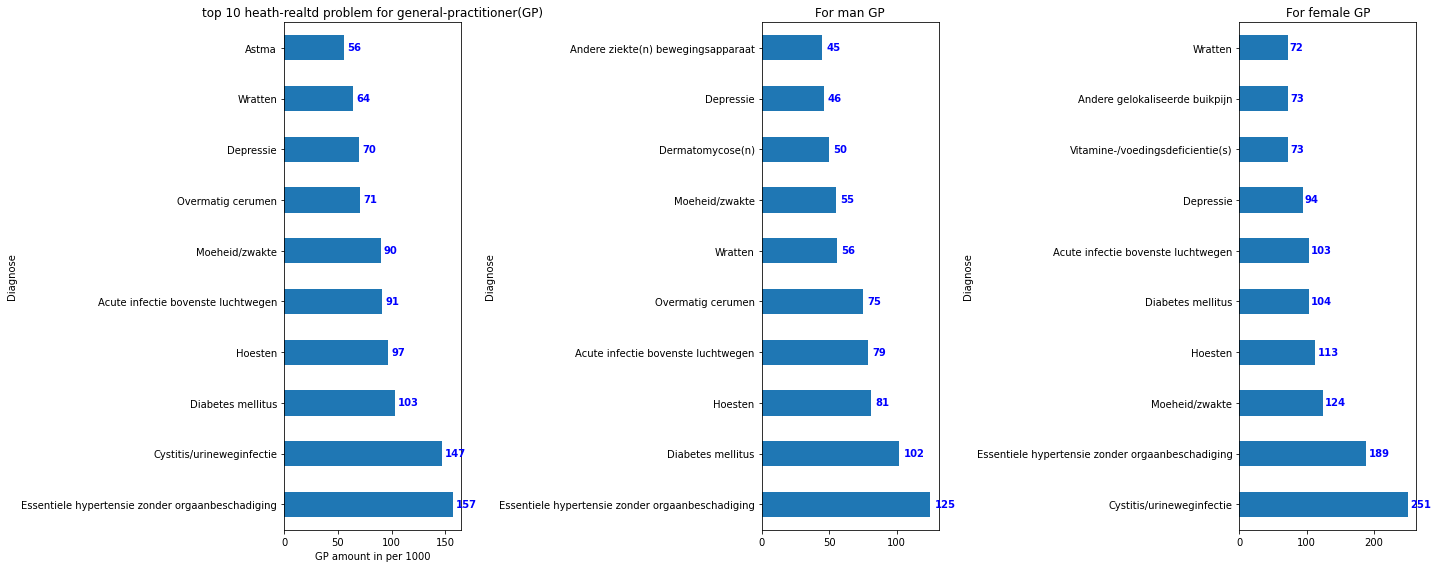

In [0]:
f, axes = plt.subplots(1, 3,figsize=(20,8))
a_prob.plot.barh(x='Diagnose', y='aantal_1000', legend=False, title= 'top 10 heath-realtd problem for general-practitioner(GP)', ax=axes[0])
big_vals = a_prob['aantal_1000'].values.tolist()
for i, v in enumerate(a_prob['aantal_1000'].values.tolist()):
    axes[0].text(big_vals[i]+3, i-.05, str(v), color='blue', fontweight='bold')
axes[0].set_xlabel("GP amount in per 1000")

m_prob.plot.barh(x='Diagnose', y='aantal_1000', legend=False, title= 'For man GP', ax=axes[1])
big_vals = m_prob['aantal_1000'].values.tolist()
for i, v in enumerate(m_prob['aantal_1000'].values.tolist()):
    axes[1].text(big_vals[i]+3, i-.05, str(v), color='blue', fontweight='bold')
axes[0].set_xlabel("GP amount in per 1000")

w_prob.plot.barh(x='Diagnose', y='aantal_1000', legend=False, title= 'For female GP', ax=axes[2])
big_vals = w_prob['aantal_1000'].values.tolist()
for i, v in enumerate(w_prob['aantal_1000'].values.tolist()):
    axes[2].text(big_vals[i]+3, i-.05, str(v), color='blue', fontweight='bold')
axes[0].set_xlabel("GP amount in per 1000")

f.tight_layout()


## Data collected from [volksgezondheidenzorg](https://www.volksgezondheidenzorg.info/)

Likewise, this dataset also only cintain analyzed dataset rather than raw data.
<br/>
<br/>
This dataset mainly contains problem distribution by gemeentename or GGDregio.  I combined some tables into one table `volksgezondheidenzorg_gemeentenaam`.  Other remained tables are: `alcohol_nieuw`,`chronischeziekten`,`eenzaamheid`,`eigenregie`,`ervarengezondheid`,`fysiekeomgeving`,`gehoorstoornissen`,`gezenqzorggebruik`,`gezichtsstoornissen`,`jogg20190930`,`klik_gli_maart2020`,`klikfilemishandeling`,`landelijkprogramma_201804`,`lichamelijkfunctioneren`,`mantelzorg`,`overgewicht`,`psychischeongezondheid`,`qry003_klik2017`,`qry003klik2017`,`roken_0`,`smap2016vzinfo_ernstige_geluidhinder_spoorwegen`,`smap2016vzinfo_ernstige_geluidhinder_vliegtuigen`,`smap2016vzinfo_ernstige_geluidhinder_wegen_boven_50_kmu`,`smap2016vzinfo_ernstige_geluidhinder_wegen_onder_50_kmu`,`smap2016vzinfo_richtlijn_beweeg`,`smap2016vzinfo_roker`,`smap2016vzinfo_sporter`,`smap2016vzinfo_vrwwerk`,`smap2016vzinfo_ziek_lang` and `vrijwillig`.

Below I plot some porblem percentages for enschede.

In [0]:
q = '''
select *
from eci-workspace-rachel.volksgezondheidenzorg.volksgezondheidenzorg_gemeentenaam
where Gemeente = 'Enschede'
'''
enschede_df = bq_client.query(q).to_dataframe()

In [0]:
enschede_df = enschede_df.T.reset_index().rename(columns={'index':'col_name',0:'percentage'})

In [0]:
enschede_df = enschede_df[~enschede_df['col_name'].isin(['id','Gemeente','fietsgebruik2017klik','kindmethandicap_2015'])]
enschede_df['percentage'] = enschede_df['percentage'].astype(str)
enschede_df['percentage'] = enschede_df['percentage'].str.replace(',', '.')
enschede_df['percentage'] = enschede_df['percentage'].astype(float)

Text(0.5, 0, 'percentage (overall population)')

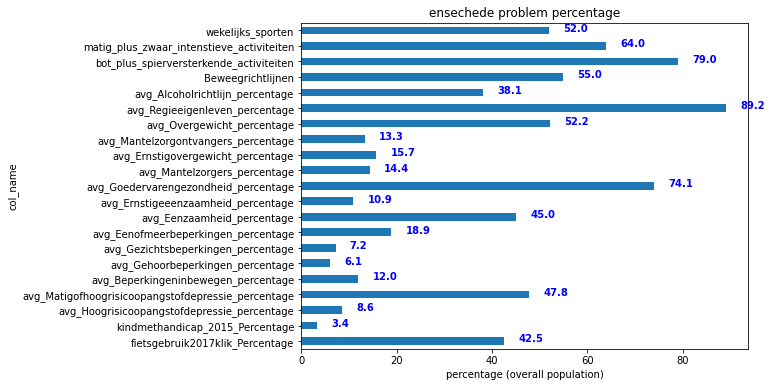

In [0]:
axes = enschede_df.plot.barh(x='col_name', y='percentage', legend=False, 
                             title= 'ensechede problem percentage',
                             figsize = (8,6))
big_vals = enschede_df['percentage'].values.tolist()
for i, v in enumerate(enschede_df['percentage'].values.tolist()):
    axes.text(big_vals[i]+3, i-.05, str(v), color='blue', fontweight='bold')
axes.set_xlabel("percentage (overall population)")

## Some other might useful open dataset/info:

- [Drug-usage info](https://www.sfk.nl/publicaties/data-en-feiten):  pdf reports.
> Data and facts is the annual publication of the Foundation for Pharmaceutical Key Figures (SFK). This publication provides a comprehensive overview of drug use in the Netherlands, provided through public pharmacies. Data and facts contains statistics about developments in pharmacy, such as price developments of medicines, reimbursements for pharmaceutical care, use of medicines for common disorders and the top 10 most frequently dispensed medicines.
View the most recent release of Dates and Facts.
- [Patient Info](http://www.pharmo.nl/what-we-have/pharmo-database-network/): need request.
- [Infectious Diseases Surveillance Information System - Antibiotics Resistance](https://www.rivm.nl/isis-ar/overzichten-van-gegevens/gegevensverzoek): need request.
<!-- - [Leefstijl, gezondheid, zorggebruik Caribisch Nederland](https://www.cbs.nl/nl-nl/maatwerk/2019/23/leefstijl-gezondheid-zorggebruik-caribisch-nederland) -->
- [Health by neighborhood, district and municipality](https://www.rivm.nl/media/smap/index.html): 
> This website presents maps and figures on health and health-related themes at municipal, district and neighborhood level

- [Healthcare insights in fact sheets](https://www.vektis.nl/actueel?types=feiten-cijfers)

- [Allecijfers](https://allecijfers.nl/):
> Clear information in numbers and graphs. Based on sources from many different official open data providers.


## Some interesting COVID19 websites


- [NL data in github](https://github.com/J535D165/CoronaWatchNL)
  - [Interesting plot/apps about cornovrius in NL](https://nlcovid-19-esrinl-content.hub.arcgis.com/pages/apps)
- [Overview dataset](https://www.databronnencovid19.nl/)
- [Transmition of coronvirus](https://nextstrain.org/ncov?animate=2019-12-09,2020-04-05,0,0,30000)
- Word map about cornovirus: [this](https://who.sprinklr.com/) and [this](https://www.google.com/covid19-map/)
- Statistics on Coronavirus and COVID-19
[this](https://allecijfers.nl/nieuws/statistieken-over-het-corona-virus-en-covid19/) 

- [mobility tracked by phone](https://www.google.com/covid19/mobility/): pdf report

- [Coronavirus Disease (COVID-19) – Statistics and Research](https://ourworldindata.org/coronavirus)


Something might be helpful for coronavirus related NLP
- [Papers about cornavirus](https://pages.semanticscholar.org/coronavirus-research)
- [Global research on coronavirus disease](https://www.who.int/emergencies/diseases/novel-coronavirus-2019/global-research-on-novel-coronavirus-2019-ncov)